## Overview 
1. Data analysis of given data
2. Check Covariance
3. ??

# 1.Data analysis of given data
The goal of this analysis is to visulaize and clean if neccessay ... 

In [29]:
# import packages 
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt

# import data
dwd_demand = nc.Dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = nc.Dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = nc.Dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = nc.Dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = nc.Dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = nc.Dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

# weather data
datasets = {
    "DWD Demand": dwd_demand,
    "DWD Hornsea": dwd_hornsea,
    "DWD PES10": dwd_pes10,
    "NCEP Demand": ncep_demand,
    "NCEP Hornsea": ncep_hornsea,
    "NCEP PES10": ncep_pes10
}

# demand data
demand_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")

# Explore data, look at variables, dimensions ect.

In [30]:
# Show variables, dimensions, shapes, and units of a dataset 
def describe_nc_dataset(dataset, dataset_name):
    print(f"\nOverview of {dataset_name}")   
    for var in dataset.variables.values():
        name = var.name 
        dims = var.dimensions
        shape = var.shape
        units = var.units if 'units' in var.ncattrs() else 'N/A'
        print(f"{name}: {dims} {shape} {units}")

for name, ds in datasets.items():
    describe_nc_dataset(ds, name)

print("n\Overview of Demand Data")
print(demand_data.info())
print(demand_data.head())


Overview of DWD Demand
RelativeHumidity: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
Temperature: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
TotalPrecipitation: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
WindDirection: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
WindSpeed: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
latitude: ('point',) (7,) N/A
longitude: ('point',) (7,) N/A
point: ('point',) (7,) N/A
ref_datetime: ('ref_datetime',) (4467,) hours since 2022-09-18T06:00:00
valid_datetime: ('valid_datetime',) (93,) N/A

Overview of DWD Hornsea
RelativeHumidity: ('ref_datetime', 'valid_datetime', 'latitude', 'longitude') (4467, 93, 6, 6) N/A
Temperature: ('ref_datetime', 'valid_datetime', 'latitude', 'longitude') (4467, 93, 6, 6) N/A
WindDirection: ('ref_datetime', 'valid_datetime', 'latitude', 'longitude') (4467, 93, 6, 6) N/A
WindDirection:100: ('ref_datetime', 'valid_datetime', 'latitude', 'lo

# Check Missing Values

In [7]:
def check_missing_values(dataset, dataset_name):
    print(f"\nChecking missing values for: {dataset_name}")
    has_missing = False
    
    for var_name in dataset.variables:
        var = dataset.variables[var_name]
        missing_count = pd.isnull(var[:]).sum()
        
        if missing_count > 0:
            if not has_missing:
                print("Variables with missing values:")
                has_missing = True
            print(f"- {var_name}: {missing_count} missing values")
    
    if not has_missing:
        print("No missing values found in any variable")
    
for name, dataset in datasets.items():
    check_missing_values(dataset, name)

print("\nChecking missing values for Demand Data")
print(demand_data.isnull().sum())


Checking missing values for: DWD Demand
No missing values found in any variable

Checking missing values for: DWD Hornsea
No missing values found in any variable

Checking missing values for: DWD PES10
No missing values found in any variable

Checking missing values for: NCEP Demand
No missing values found in any variable

Checking missing values for: NCEP Hornsea
No missing values found in any variable

Checking missing values for: NCEP PES10
No missing values found in any variable

Checking missing values for Demand Data
dtm                                0
MIP                              321
Solar_MW                          75
Solar_capacity_mwp                 0
Solar_installedcapacity_mwp        0
Wind_MW                          103
SS_Price                           0
boa_MWh                          103
DA_Price                           0
Unnamed: 9                     54384
Unnamed: 10                    54384
Unnamed: 11                    54384
Unnamed: 12               

# Check Time and Frequency

In [ ]:
def inspect_time(dataset, dataset_name):
    print(f"\nStart and Stop Times for {dataset_name}:")
    time_var = dataset.variables["ref_datetime"]
    print(f"Units: {time_var.units}")
    print(f"Start: {nc.num2date(time_var[0], time_var.units)}")
    print(f"End: {nc.num2date(time_var[-1], time_var.units)}")

def inspect_frequency(dataset, dataset_name):
    """Compact frequency analysis printer"""
    print(f"\nTime Measurement Frequencies for {dataset_name}:")
    diffs = pd.Series(dataset.variables["ref_datetime"][:]).diff().dropna()
    
    # Print frequency table
    for interval, count in diffs.value_counts().sort_index().items():
        print(f"{interval}: {count} occurrences")
    
    # Print quick stats
    print(f"\nTotal measurements: {len(diffs)+1}")
    print(f"Unique intervals: {diffs.nunique()}")

def find_largest_gap(dataset, dataset_name):
    print(f"\n Searching for largest time gap in {dataset_name}...")
    
    time_var = dataset.variables["ref_datetime"]
    time_vals = nc.num2date(time_var[:], units=time_var.units)

    # Convert to pandas Series for diffing
    time_series = pd.Series(time_vals)
    time_deltas = time_series.diff().dropna()

    # Find the max gap
    max_gap = time_deltas.max()
    max_gap_index = time_deltas.idxmax()

    before = time_series[max_gap_index - 1]
    after = time_series[max_gap_index]

    print(f"Largest gap: {max_gap}")
    print(f"Before: {before}")
    print(f"After:  {after}")


for name, dataset in datasets.items():
    inspect_time(dataset, name)
    inspect_frequency(dataset, name)
    find_largest_gap(dataset, name)


# Load the CSV file (replace with your actual file name)
df =  pd.read_csv("data/Energy_Data_20200920_20231027.csv")

# Convert "dtm" to datetime (ISO 8601, with UTC timezone)
df["dtm"] = pd.to_datetime(df["dtm"], utc=True)

# Sort just in case
df = df.sort_values("dtm")

# Calculate time deltas in hours
time_diffs = df["dtm"].diff().dropna().dt.total_seconds() / 3600

# Frequency summary
interval_counts = time_diffs.value_counts().sort_index()

# Display start and end times
start_time = df["dtm"].iloc[0]
end_time = df["dtm"].iloc[-1]

print(f"Start time: {start_time}")
print(f"End time:   {end_time}\n")

# Display time interval frequencies
for interval, count in interval_counts.items():
    print(f"{interval:.1f}: {int(count)} occurrences")

print(f"\nTotal measurements: {len(df)}")
print(f"Unique intervals: {interval_counts.count()}")



Start and Stop Times for DWD Demand:
Units: hours since 2022-09-18T06:00:00
Start: 2020-09-20 00:00:00
End: 2023-10-27 00:00:00

Time Measurement Frequencies for DWD Demand:
6.0: 4458 occurrences
12.0: 6 occurrences
18.0: 1 occurrences
330.0: 1 occurrences

Total measurements: 4467
Unique intervals: 4

 Searching for largest time gap in DWD Demand...
🚨 Largest gap: 13 days 18:00:00
Before: 2022-11-23 00:00:00
After:  2022-12-06 18:00:00

Start and Stop Times for DWD Hornsea:
Units: hours since 2022-09-18T06:00:00
Start: 2020-09-20 00:00:00
End: 2023-10-27 00:00:00

Time Measurement Frequencies for DWD Hornsea:
6.0: 4458 occurrences
12.0: 6 occurrences
18.0: 1 occurrences
330.0: 1 occurrences

Total measurements: 4467
Unique intervals: 4

 Searching for largest time gap in DWD Hornsea...
🚨 Largest gap: 13 days 18:00:00
Before: 2022-11-23 00:00:00
After:  2022-12-06 18:00:00

Start and Stop Times for DWD PES10:
Units: hours since 2022-09-18T06:00:00
Start: 2020-09-20 00:00:00
End: 2023-

# Visualize Data

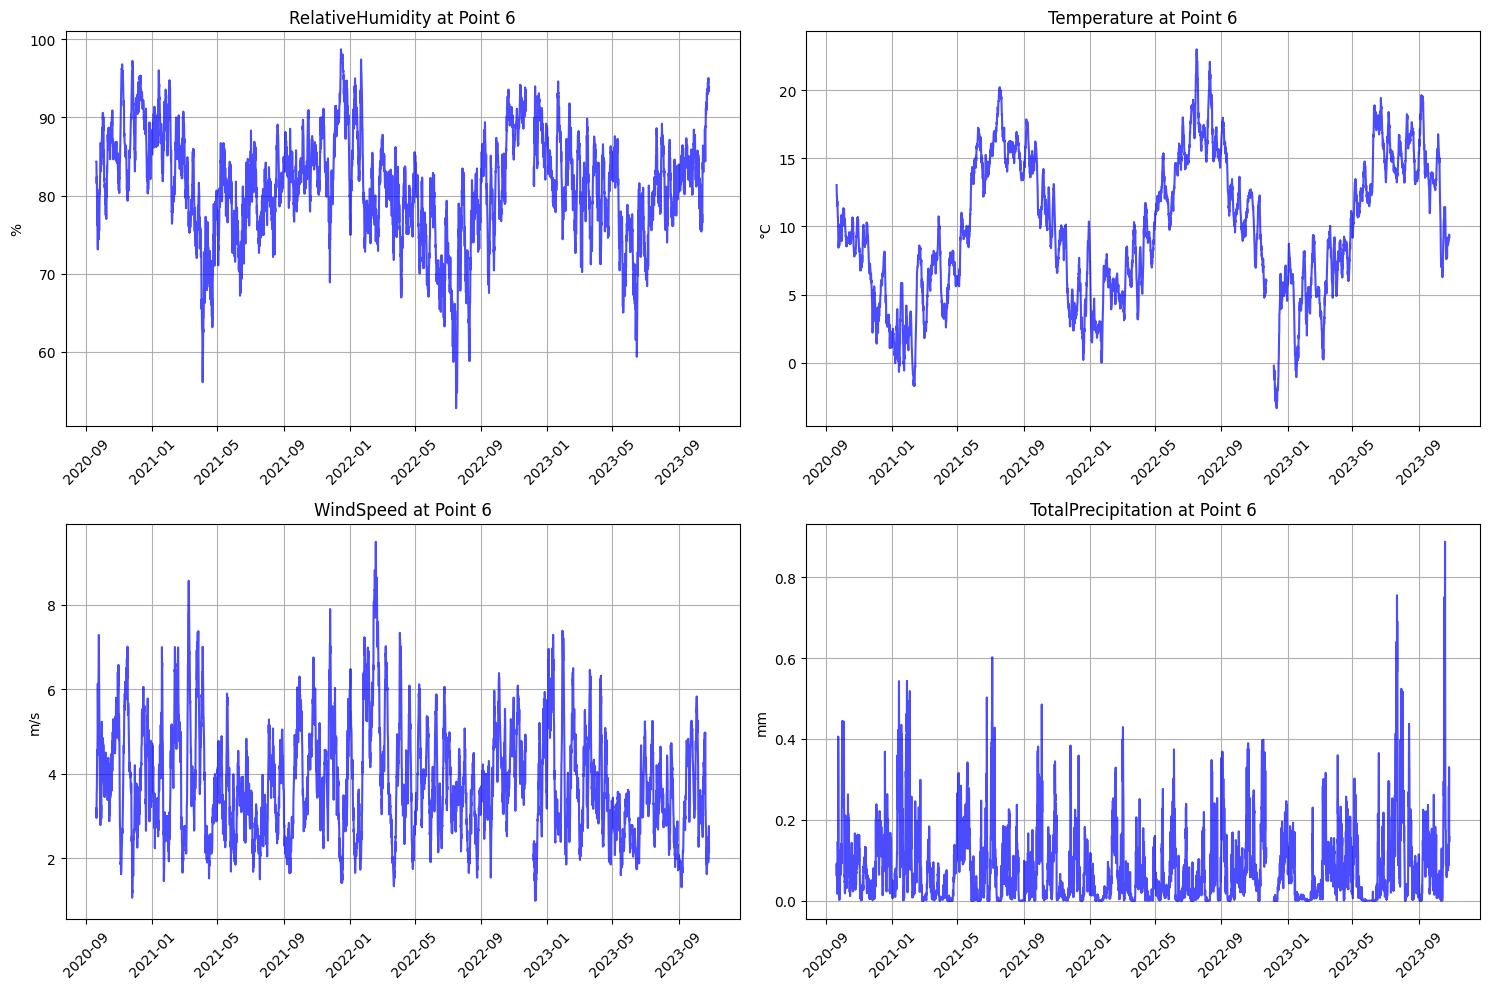

In [5]:
from datetime import datetime

# Configuration
point_idx = 6  # Which location to plot (0-6)
variables = ['RelativeHumidity', 'Temperature', 'WindSpeed', 'TotalPrecipitation']
units = ['%', '°C', 'm/s', 'mm']

# Create figure
plt.figure(figsize=(15, 10))

# Convert reference times to datetime
ref_times = nc.num2date(dwd_demand.variables['ref_datetime'][:],
                       dwd_demand.variables['ref_datetime'].units)
ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]

# Plot each variable
for i, (var, unit) in enumerate(zip(variables, units), 1):
    # Get and aggregate data
    data = dwd_demand.variables[var][:, :, point_idx]  # [ref, valid, point]
    mean_values = np.nanmean(data, axis=1)  # Handles any NaN values
    
    # Create subplot
    plt.subplot(2, 2, i)
    plt.plot(ref_times_datetime, mean_values, 'b-', alpha=0.7)
    plt.title(f'{var} at Point {point_idx}')
    plt.ylabel(unit)
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

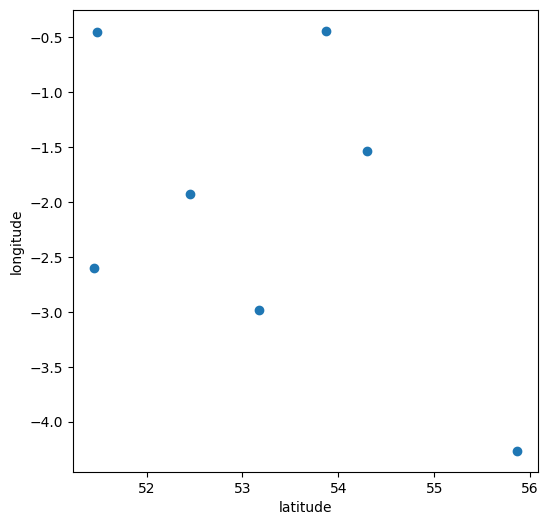

In [6]:
points = dwd_demand.variables['point'][:] # 0 1 2 3 4 5 6 
lats = dwd_demand.variables['latitude'][:]
lons = dwd_demand.variables['longitude'][:]

# Plot latitide and longitude
plt.figure(figsize=(6, 6))
plt.plot(lats, lons, 'o')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()


In [ ]:
print("start")

# extract powers
dtm_demand = demand_data["dtm"]
solar_MW_05h = demand_data["Solar_MW"]
wind_MW_05h = demand_data["Wind_MW"]
production_MW_05h = solar_MW_05h + wind_MW_05h

# look at first missing values
#first_nan_index = production_MW_05h.isna().idxmax()
#print(first_nan_index)
# Solar -> 12485
# Wind -> 20208
# Both -> 12485 

#dtm_demand.iloc[12485]
# 2021-06-07T02:30:00Z
# closest index 12480 -> 2021-06-07T00:00:00

# Readjust powers
solar_MW_6h = solar_MW_05h.iloc[0:12480].groupby(np.arange(12480)//12).mean().reset_index(drop=True)
wind_MW_05h = wind_MW_05h.iloc[0:12480].groupby(np.arange(12480)//12).mean().reset_index(drop=True)
production_MW_05h = production_MW_05h.iloc[0:12480].groupby(np.arange(12480)//12).mean().reset_index(drop=True)
# len ->12480/12 = 1040

# find index for weather data
#ref_times = nc.num2date(dwd_hornsea.variables['ref_datetime'][:],
#                       dwd_hornsea.variables['ref_datetime'].units)
#ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]
#print(ref_times_datetime[1034]) -> index 1034 (dwd_demand, dwd_hornsea, dwd_pes10)

point_idx = 1
weather_idx = 1040
# Fuck it use 1039 to get the vectors the same lengt
dwd_demand_RelativeHumidity = dwd_demand.variables["RelativeHumidity"][0:weather_idx, :, point_idx]
dwd_demand_Temperature = dwd_demand.variables["Temperature"][0:weather_idx, :, point_idx]
dwd_demand_TotalPrecipitation = dwd_demand.variables["TotalPrecipitation"][0:weather_idx, :, point_idx]
dwd_demand_WindDirection = dwd_demand.variables["WindDirection"][0:weather_idx, :, point_idx]
dwd_demand_WindSpeed = dwd_demand.variables["WindSpeed"][0:weather_idx, :, point_idx]

print(dwd_demand_WindSpeed.shape)
# dwd_hornsea 
dwd_pes10_CloudCover = dwd_pes10.variables["CloudCover"][0:weather_idx, :, point_idx]
dwd_pes10_SolarDownwardRadiation = dwd_pes10.variables["SolarDownwardRadiation"][0:weather_idx, :, point_idx]
dwd_pes10_Temperature = dwd_pes10.variables["Temperature"][0:weather_idx, :, point_idx]

# Step 1: Average weather data over the second axis (valid_datetime)
def avg_over_valid_dim(var):
    return var.mean(axis=1)

# Step 2: Create DataFrame
df_cov = pd.DataFrame({
    "Solar_MW": solar_MW_6h[:1040],
    "Wind_MW": wind_MW_05h[:1040],
    "Total_Production": production_MW_05h[:1040],
    "RelHumidity": avg_over_valid_dim(dwd_demand_RelativeHumidity),
    "Temp_demand": avg_over_valid_dim(dwd_demand_Temperature),
    "Precip": avg_over_valid_dim(dwd_demand_TotalPrecipitation),
    "WindDir": avg_over_valid_dim(dwd_demand_WindDirection),
    "WindSpeed": avg_over_valid_dim(dwd_demand_WindSpeed),
    "CloudCover": avg_over_valid_dim(dwd_pes10_CloudCover),
    "SolarRad": avg_over_valid_dim(dwd_pes10_SolarDownwardRadiation),
    "Temp_PES10": avg_over_valid_dim(dwd_pes10_Temperature)
})

# Step 4: Compute and visualize the covariance matrix
cov_matrix = df_cov.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Covariance Matrix of Power Production and Weather Features")
plt.tight_layout()
plt.show()

# Preprocessing Data for Random Forest

We don't need to care about oulier data, this means we don't need to take mean or log to the data to make it more even.
To prefrocess the data we will do some data cleaning this entails fix missing values, fitt the data together so their on the same time-axis to the production time half hour resolution.   


Regarding splitting of data according to Xaviaer we could split the data at the large time gap, after the gap data will be used for training, before data will be slpit 90% for training and the last 10% for validation. Where crossvalidation will be preformed.


Other recomendations:
1. Temporal interpolation (data repair)
2. OneHotEncoder (dummy creation if needed)
3. Rekomended to use around 500 trees


In [ ]:
# import packages 
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# import data

# Weather data 
dwd_demand = nc.Dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = nc.Dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = nc.Dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = nc.Dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = nc.Dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = nc.Dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

# energy data
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv") 

# Functions
def extract_variable_data(var, idx, ref_times, e_dtm):
    """
    Inputs: NC variable "var", point index "idx", referance time for variable "ref_t"
            and dtm for energy data "e_dtm"
    
    Fills in the referance times in with values from valid time (eavenly spaced),
    then use temporal interpolation to generate x2

    Returns x2 interpolated values for variable allong e_dtm axis
    """
    ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]

    # alloc mem 
    n_tot = (var.shape[0])*(var.shape[1])
    values = np.empty(n_tot, dtype = "float32")
    times = np.empty(n_tot, dtype = "datetime64[ns]")

    count  = 0

    for i in range(var.shape[0]):
        # print(str(i)) if you want to se progress but slow it down 
        if i == var.shape[0]-1:
            ref_dt_start = ref_times_datetime[i]
            ref_dt_end = ref_dt_start + timedelta(hours=6)
        else:
            ref_dt_start = ref_times_datetime[i]
            ref_dt_end = ref_times_datetime[i + 1]	

        start_ns = np.datetime64(ref_dt_start, 'ns').astype('int64')
        end_ns = np.datetime64(ref_dt_end, 'ns').astype('int64')

        time_steps_ns = np.linspace(start_ns, end_ns, var.shape[1] + 1)

        time_steps = time_steps_ns.astype('datetime64[ns]')

        # for every valid time in referance time
        for j in range(var.shape[1]):
            if var[i, j, idx] is np.ma.masked:
                values[count] = np.nan
                times[count] = time_steps[j]
                count += 1

            else: 
                values[count] = np.mean(var[i,j,idx])
                times[count] = time_steps[j]
                count += 1

    t1 = pd.to_datetime(times, utc=True)
    t2 = pd.to_datetime(e_dtm, utc=True)

    combined_index = pd.DatetimeIndex(t1.union(t2)).sort_values()

    x1 = pd.Series(values, index=pd.DatetimeIndex(t1))

    x1_reindexed = x1.reindex(combined_index)

    assert isinstance(x1_reindexed.index, pd.DatetimeIndex)

    x1_interpolated = x1_reindexed.interpolate(method='time')

    x2 = x1_interpolated.loc[t2]

    return x2

    
# 1. Parse variables
dwd_demand_RelativeHumidity = dwd_demand["RelativeHumidity"]
dwd_demand_Temperature = dwd_demand["Temperature"]
dwd_demand_TotalPrecipitation = dwd_demand["TotalPrecipitation"]
dwd_demand_WindDirection = dwd_demand["WindDirection"]
dwd_demand_WindSpeed = dwd_demand["WindSpeed"]

dwd_hornsea_RelativeHumidity = dwd_hornsea["RelativeHumidity"]
dwd_hornsea_Temperature = dwd_hornsea["Temperature"]
dwd_hornsea_WindDirection = dwd_hornsea["WindDirection"]
dwd_hornsea_WindDirection100 = dwd_hornsea["WindDirection:100"]
dwd_hornsea_WindSpeed = dwd_hornsea["WindSpeed"]
dwd_hornsea_WindSpeed100 = dwd_hornsea["WindSpeed:100"]

dwd_pes10_CloudCover = dwd_pes10["CloudCover"]
dwd_pes10_SolarDownwardRadiation = dwd_pes10["SolarDownwardRadiation"]
dwd_pes10_Temperature = dwd_pes10["Temperature"]

ncep_demand_RelativeHumidity = ncep_demand["RelativeHumidity"]
ncep_demand_Temperature = ncep_demand["Temperature"]
ncep_demand_TotalPrecipitation = ncep_demand["TotalPrecipitation"]
ncep_demand_WindDirection = ncep_demand["WindDirection"]
ncep_demand_WindSpeed = ncep_demand["WindSpeed"]

ncep_hornsea_RelativeHumidity = ncep_hornsea["RelativeHumidity"]
ncep_hornsea_Temperature = ncep_hornsea["Temperature"]
ncep_hornsea_WindDirection = ncep_hornsea["WindDirection"]
ncep_hornsea_WindDirection100 = ncep_hornsea["WindDirection:100"]
ncep_hornsea_WindSpeed = ncep_hornsea["WindSpeed"]
ncep_hornsea_WindSpeed100 = ncep_hornsea["WindSpeed:100"]

energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]

# 2.1 Repair energy data, there are no time gaps but some NaNs
# Simply use linear interpolisation 

energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)

# Now comes the shit of handeling the weather data


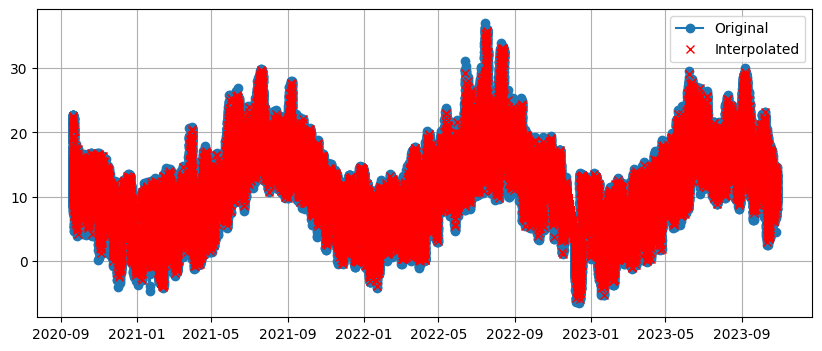

In [ ]:
# Test block for function

# Inputs 
idx = 1 
var = dwd_demand_Temperature
ref_times = nc.num2date(dwd_demand.variables['ref_datetime'][:],
                       dwd_demand.variables['ref_datetime'].units)
ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]

# alloc mem 
n_tot = (var.shape[0])*(var.shape[1])
values = np.empty(n_tot, dtype = "float32")
times = np.empty(n_tot, dtype = "datetime64[ns]")

count  = 0

# for every referance time
for i in range(var.shape[0]):
    # print(str(i)) if you want to se progress but slow it down 
    if i == var.shape[0]-1:
        ref_dt_start = ref_times_datetime[i]
        ref_dt_end = ref_dt_start + timedelta(hours=6)
    else:
        ref_dt_start = ref_times_datetime[i]
        ref_dt_end = ref_times_datetime[i + 1]	

    # Convert to datetime64[ns] explicitly
    start_ns = np.datetime64(ref_dt_start, 'ns').astype('int64')
    end_ns = np.datetime64(ref_dt_end, 'ns').astype('int64')

    # Generate linear space in nanoseconds
    time_steps_ns = np.linspace(start_ns, end_ns, var.shape[1] + 1)

    # Convert back to datetime64[ns]
    time_steps = time_steps_ns.astype('datetime64[ns]')

    # for every valid time in referance time
    for j in range(var.shape[1]):
        if var[i, j, idx] is np.ma.masked:
            values[count] = np.nan
            times[count] = time_steps[j]
            count += 1

        else: 
            values[count] = np.mean(var[i,j,idx])
            times[count] = time_steps[j]
            count += 1

t1 = pd.to_datetime(times, utc=True)
t2 = pd.to_datetime(energy_data_dtm, utc=True)

# Combine and sort unique timestamps
combined_index = pd.DatetimeIndex(t1.union(t2)).sort_values()

# Create the Series with t1
x1 = pd.Series(values, index=pd.DatetimeIndex(t1))

# Reindex to combined time axis
x1_reindexed = x1.reindex(combined_index)

# Check to make sure it's still a DatetimeIndex
assert isinstance(x1_reindexed.index, pd.DatetimeIndex)

# Interpolate
x1_interpolated = x1_reindexed.interpolate(method='time')

# Extract the values at your target timestamps
x2 = x1_interpolated.loc[t2]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(x1.index, x1.values, 'o-', label='Original')
plt.plot(x2.index, x2.values, 'xr', label='Interpolated')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test = nc.num2date(dwd_demand.variables['ref_datetime'][:],
                       dwd_demand.variables['ref_datetime'].units)

result = extract_variable_data(var = dwd_demand_Temperature,
    idx = 1,
    ref_times = test,
    e_dtm = energy_data_dtm)



# This is great and all I've done is enter my name, Thillho 
## ~ Milhouse Mussolini Van Houten

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
#import tensorflow as tf 
#import keras
import matplotlib.pyplot as plt

# Loacal funcions
def interpolate_weather_variable(ds, var_name, point_idx, energy_data_dtm):
    """
    Interpolates a weather variable from an xarray.Dataset to match energy data timestamps.

    Parameters:
        ds (xarray.Dataset): The dataset containing weather data.
        var_name (str): Name of the variable in ds (e.g., "Temperature").
        point_idx (int): Index of the point to extract.
        energy_data_dtm (array-like): Timestamps of energy data.

    Returns:
        pd.Series: Interpolated weather variable values aligned with energy_data_dtm.
    """
    # Extract variable values and associated times
    var = ds[var_name][:, :, point_idx].values
    ref_times = pd.to_datetime(ds["ref_datetime"].values)
    valid_offsets = ds["valid_datetime"].values  # hours ahead

    # Flatten into timestamp-value pairs
    all_datetimes = []
    all_values = []
    for i, ref_time in enumerate(ref_times):
        for j, offset in enumerate(valid_offsets):
            forecast_time = ref_time + pd.Timedelta(hours=int(offset))
            value = var[i, j]
            if not np.isnan(value):
                all_datetimes.append(forecast_time)
                all_values.append(value)

    # Make sure energy timestamps are a proper DatetimeIndex
    energy_timestamps = pd.to_datetime(energy_data_dtm)
    energy_timestamps = pd.DatetimeIndex(energy_timestamps).tz_localize(None)

    # Create initial Series
    ts = pd.Series(all_values, index=pd.DatetimeIndex(all_datetimes)).tz_localize(None)

    # Average duplicates (if any)
    ts = ts.groupby(ts.index).mean()

    # Combine, sort and interpolate
    combined_index = pd.DatetimeIndex(ts.index.union(energy_timestamps)).sort_values()
    ts_interpolated = ts.reindex(combined_index).interpolate(method='time')

    # Return only the values aligned with energy timestamps
    return ts_interpolated.loc[energy_timestamps]

def interpolate_var_flexible(ds, var_name, energy_data_dtm, lat_idx=None, lon_idx=None):
    """
    Interpolates a lat-lon-based weather variable to match energy data timestamps.

    Parameters:
        ds (xarray.Dataset): The dataset containing the variable.
        var_name (str): Variable name to interpolate.
        energy_data_dtm (array-like): Target timestamps (from energy data).
        lat_idx (int, optional): Index of latitude to extract. Required if not doing diagonal.
        lon_idx (int, optional): Index of longitude to extract. Required if not doing diagonal.

    Returns:
        pd.Series or pd.DataFrame: Interpolated time-aligned Series or DataFrame (if diagonal).
    """
    energy_timestamps = pd.to_datetime(energy_data_dtm)
    energy_timestamps = pd.DatetimeIndex(energy_timestamps).tz_localize(None)

    ref_times = pd.to_datetime(ds["ref_datetime"].values)
    valid_offsets = ds["valid_datetime"].values  # hours ahead

    # Handle diagonal case if no specific lat/lon is passed
    if lat_idx is None and lon_idx is None:
        lat_len = ds.dims["latitude"]
        lon_len = ds.dims["longitude"]
        assert lat_len == lon_len, "Latitude and longitude dimensions must match for diagonal extraction."

        df = pd.DataFrame(index=energy_timestamps)

        for idx in range(lat_len):
            var = ds[var_name][:, :, idx, idx].values  # diagonal extraction
            all_datetimes = []
            all_values = []

            for i, ref_time in enumerate(ref_times):
                for j, offset in enumerate(valid_offsets):
                    forecast_time = ref_time + pd.Timedelta(hours=int(offset))
                    value = var[i, j]
                    if not np.isnan(value):
                        all_datetimes.append(forecast_time)
                        all_values.append(value)

            ts = pd.Series(all_values, index=pd.DatetimeIndex(all_datetimes)).tz_localize(None)
            ts = ts.groupby(ts.index).mean()
            combined_index = ts.index.union(energy_timestamps).sort_values()
            ts_interpolated = ts.reindex(combined_index).interpolate(method='time')

            df[f"{var_name}_P{idx}"] = ts_interpolated.loc[energy_timestamps].values

        return df

    # Else, handle single point selection (lat_idx and lon_idx must be provided)
    var = ds[var_name][:, :, lat_idx, lon_idx].values  # (ref_datetime, valid_datetime)
    all_datetimes = []
    all_values = []

    for i, ref_time in enumerate(ref_times):
        for j, offset in enumerate(valid_offsets):
            forecast_time = ref_time + pd.Timedelta(hours=int(offset))
            value = var[i, j]
            if not np.isnan(value):
                all_datetimes.append(forecast_time)
                all_values.append(value)

    ts = pd.Series(all_values, index=pd.DatetimeIndex(all_datetimes)).tz_localize(None)
    ts = ts.groupby(ts.index).mean()
    combined_index = ts.index.union(energy_timestamps).sort_values()
    ts_interpolated = ts.reindex(combined_index).interpolate(method='time')

    return ts_interpolated.loc[energy_timestamps]

dwd_demand = xr.open_dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = xr.open_dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = xr.open_dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = xr.open_dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = xr.open_dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = xr.open_dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

weather_config = [
    {
        "name": "dwd_demand",
        "ds": dwd_demand,
        "vars": ["RelativeHumidity", "Temperature", "TotalPrecipitation", "WindDirection", "WindSpeed"],
        "index": "all_points" 
    },
    {
        "name": "dwd_hornsea",
        "ds": dwd_hornsea,
        "vars": ["RelativeHumidity", "Temperature", "WindDirection", "WindSpeed"],
        "index": "all_points" 
    },
    {
        "name": "dwd_pes10",
        "ds": dwd_pes10,
        "vars": ["CloudCover", "SolarDownwardRadiation", "Temperature"],
        "index": "all_points"
    },
    {
        "name": "ncep_demand",
        "ds": ncep_demand,
        "vars": ["RelativeHumidity", "Temperature", "TotalPrecipitation", "WindDirection", "WindSpeed"],
        "index": "all_points" 
    },
    {
        "name": "ncep_hornsea",
        "ds": ncep_hornsea,
        "vars": ["RelativeHumidity", "Temperature", "WindDirection", "WindSpeed"],
        "index": "all_points" 
    },
    {
        "name": "ncep_pes10",
        "ds": ncep_pes10,
        "vars": ["CloudCover", "SolarDownwardRadiation", "Temperature"],
        "index": "all_points"
    },
]

# energy data
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv") 

energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]

# 2.1 Repair energy data, there are no time gaps but some NaNs
# Simply use linear interpolisation 

energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)


In [6]:
ds

<xarray.Dataset> Size: 70MB
Dimensions:             (ref_datetime: 4467, valid_datetime: 93, point: 7)
Coordinates:
    latitude            (point) float64 56B ...
    longitude           (point) float64 56B ...
  * point               (point) int64 56B 0 1 2 3 4 5 6
  * ref_datetime        (ref_datetime) datetime64[ns] 36kB 2020-09-20 ... 202...
  * valid_datetime      (valid_datetime) int64 744B 0 1 2 3 ... 111 114 117 120
Data variables:
    RelativeHumidity    (ref_datetime, valid_datetime, point) float32 12MB ...
    Temperature         (ref_datetime, valid_datetime, point) float32 12MB ...
    TotalPrecipitation  (ref_datetime, valid_datetime, point) float64 23MB ...
    WindDirection       (ref_datetime, valid_datetime, point) float32 12MB ...
    WindSpeed           (ref_datetime, valid_datetime, point) float32 12MB ...

In [15]:
    point_idx = 1
    var = ds["Temperature"][:, :, point_idx].values  # shape: (ref_datetime, valid_datetime)
    ref_times = pd.to_datetime(ds["ref_datetime"].values)
    valid_offsets = ds["valid_datetime"].values       # e.g., [0, 1, ..., 120]
    
    all_datetimes = []
    all_values = []

    for i, ref_time in enumerate(ref_times):
        for j, offset in enumerate(valid_offsets):
            forecast_time = ref_time + pd.Timedelta(hours=int(offset))
            value = var[i, j]

            if not np.isnan(value):
                all_datetimes.append(forecast_time)
                all_values.append(value)

    # Make sure energy timestamps are a proper DatetimeIndex
    energy_data_dtm = pd.to_datetime(energy_data_dtm)
    if isinstance(energy_data_dtm, pd.Series):
        energy_data_dtm = energy_data_dtm.values  # remove name if present
    energy_timestamps = pd.DatetimeIndex(energy_data_dtm).tz_localize(None)

    # Create the Series (already using DatetimeIndex)
    ts = pd.Series(all_values, index=pd.DatetimeIndex(all_datetimes)).tz_localize(None)

    # Remove duplicates by averaging
    ts = ts.groupby(ts.index).mean()

    # Combine and reindex
    combined_index = ts.index.union(energy_timestamps)
    combined_index = pd.DatetimeIndex(combined_index).sort_values()

    # Now safe to interpolate
    ts_reindexed = ts.reindex(combined_index)
    ts_interpolated = ts_reindexed.interpolate(method='time')

    # Final selection at target timestamps
    ts_final = ts_interpolated.loc[energy_timestamps]



In [ ]:
# Example usage of fucntion to dataframe
#test = interpolate_weather_variable(ds, "Temperature", point_idx, energy_data_dtm)

weather_features = pd.DataFrame(index=pd.to_datetime(energy_data_dtm))

for cfg in weather_config:
    ds = cfg["ds"]
    for var in cfg["vars"]:
        try:
            data_array = ds[var]
            dims = data_array.dims

            # If variable has 'point' dimension
            if "point" in dims and cfg["index"] == "all_points":
                num_points = data_array.sizes["point"]
                for p in range(num_points):
                    print(f"Interpolating {cfg['name']} - {var} - Point {p}")
                    s = interpolate_weather_variable(ds, var, p, energy_data_dtm)
                    col_name = f"{cfg['name']}_{var}_P{p}"
                    weather_features[col_name] = s.values

            # If it's a lat-lon grid, loop over all lat-lon combos
            elif "latitude" in dims and "longitude" in dims and cfg["index"] == "all_points":
                num_lat = data_array.sizes["latitude"]
                num_lon = data_array.sizes["longitude"]
                for lat_idx in range(num_lat):
                    for lon_idx in range(num_lon):
                        print(f"Interpolating {cfg['name']} - {var} - Lat {lat_idx}, Lon {lon_idx}")
                        s = interpolate_var_flexible(ds, var, energy_data_dtm,
                                                     lat_idx=lat_idx, lon_idx=lon_idx)
                        col_name = f"{cfg['name']}_{var}_Lat{lat_idx}_Lon{lon_idx}"
                        weather_features[col_name] = s.values

            else:
                # Fallback to single-point extraction
                print(f"Interpolating {cfg['name']} - {var} - Default point")
                s = interpolate_weather_variable(ds, var, point_idx=0, energy_data_dtm=energy_data_dtm)
                col_name = f"{cfg['name']}_{var}"
                weather_features[col_name] = s.values

        except Exception as e:
            print(f"⚠️ Skipped {cfg['name']} - {var}: {e}")


In [4]:
print(weather_features.shape)
print(weather_features.head())
print(weather_features.info())  
temp0 = weather_features

(54384, 370)
                           dwd_demand_RelativeHumidity_P0  \
dtm                                                         
2020-09-20 00:00:00+00:00                       85.221611   
2020-09-20 00:30:00+00:00                       87.215004   
2020-09-20 01:00:00+00:00                       89.208397   
2020-09-20 01:30:00+00:00                       90.462845   
2020-09-20 02:00:00+00:00                       91.717285   

                           dwd_demand_RelativeHumidity_P1  \
dtm                                                         
2020-09-20 00:00:00+00:00                       83.608330   
2020-09-20 00:30:00+00:00                       84.916176   
2020-09-20 01:00:00+00:00                       86.224022   
2020-09-20 01:30:00+00:00                       87.004837   
2020-09-20 02:00:00+00:00                       87.785645   

                           dwd_demand_RelativeHumidity_P2  \
dtm                                                         
2020-09-2

In [23]:
#weather_features.to_csv("weather_features.csv", index=True)



In [26]:
import pandas as pd
import numpy as np
import netCDF4 as nc


energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")
dwd_demand = nc.Dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = nc.Dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = nc.Dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = nc.Dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = nc.Dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = nc.Dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

# Konvertera "dtm" till datetime
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"], utc=True)

# Exakt tid med halvtimme
energy_data["hour_exact"] = energy_data["dtm"].dt.hour + energy_data["dtm"].dt.minute / 60

# Cyklisk tid (med halvtimme med i beräkningen)
energy_data["hour_sin"] = np.sin(2 * np.pi * energy_data["hour_exact"] / 24)
energy_data["hour_cos"] = np.cos(2 * np.pi * energy_data["hour_exact"] / 24)


# Extrahera tidskomponenter
energy_data["hour"] = energy_data["dtm"].dt.hour
energy_data["weekday"] = energy_data["dtm"].dt.weekday
energy_data["month"] = energy_data["dtm"].dt.month


energy_data["weekday_sin"] = np.sin(2 * np.pi * energy_data["weekday"] / 7)
energy_data["weekday_cos"] = np.cos(2 * np.pi * energy_data["weekday"] / 7)

energy_data["month_sin"] = np.sin(2 * np.pi * energy_data["month"] / 12)
energy_data["month_cos"] = np.cos(2 * np.pi * energy_data["month"] / 12)

def cyclic_time_from_nc(nc_dataset):
    time_var = nc_dataset.variables["ref_datetime"]
    times_raw = nc.num2date(time_var[:], units=time_var.units)

    # Konvertera varje cftime till pandas-vänlig Timestamp
    times = [pd.Timestamp(t.isoformat()) for t in times_raw]

    hour = [t.hour for t in times]
    weekday = [t.weekday() for t in times]
    month = [t.month for t in times]

    df = pd.DataFrame({
        "ref_datetime": times,
        "hour": hour,
        "hour_sin": np.sin(2 * np.pi * np.array(hour) / 24),
        "hour_cos": np.cos(2 * np.pi * np.array(hour) / 24),
        "weekday": weekday,
        "weekday_sin": np.sin(2 * np.pi * np.array(weekday) / 7),
        "weekday_cos": np.cos(2 * np.pi * np.array(weekday) / 7),
        "month": month,
        "month_sin": np.sin(2 * np.pi * np.array(month) / 12),
        "month_cos": np.cos(2 * np.pi * np.array(month) / 12),
    })

    return df


cyclic_dwd_demand = cyclic_time_from_nc(dwd_demand)
cyclic_dwd_hornsea = cyclic_time_from_nc(dwd_hornsea)
cyclic_dwd_pes10 = cyclic_time_from_nc(dwd_pes10)
cyclic_ncep_demand = cyclic_time_from_nc(ncep_demand)
cyclic_ncep_hornsea = cyclic_time_from_nc(ncep_hornsea)
cyclic_ncep_pes10 = cyclic_time_from_nc(ncep_pes10)


print(energy_data[["dtm", "hour_exact", "hour_sin", "hour_cos"]].head(10))


cyclic_dfs = {
    "cyclic_dwd_demand": cyclic_dwd_demand,
    "cyclic_dwd_hornsea": cyclic_dwd_hornsea,
    "cyclic_dwd_pes10": cyclic_dwd_pes10,
    "cyclic_ncep_demand": cyclic_ncep_demand,
    "cyclic_ncep_hornsea": cyclic_ncep_hornsea,
    "cyclic_ncep_pes10": cyclic_ncep_pes10
}

for name, df in cyclic_dfs.items():
    print(f"\n {name}")
    print(f"- Antal rader: {len(df)}")
    print(f"- Kolumner: {df.columns.tolist()}")
    print(f"- Tidsintervall: {df['ref_datetime'].min()} → {df['ref_datetime'].max()}")
    print("- Första 3 rader:")
    print(df.head(3))

#print(cyclic_dwd_hornsea.head())

                        dtm  hour_exact  hour_sin  hour_cos
0 2020-09-20 00:00:00+00:00         0.0  0.000000  1.000000
1 2020-09-20 00:30:00+00:00         0.5  0.130526  0.991445
2 2020-09-20 01:00:00+00:00         1.0  0.258819  0.965926
3 2020-09-20 01:30:00+00:00         1.5  0.382683  0.923880
4 2020-09-20 02:00:00+00:00         2.0  0.500000  0.866025
5 2020-09-20 02:30:00+00:00         2.5  0.608761  0.793353
6 2020-09-20 03:00:00+00:00         3.0  0.707107  0.707107
7 2020-09-20 03:30:00+00:00         3.5  0.793353  0.608761
8 2020-09-20 04:00:00+00:00         4.0  0.866025  0.500000
9 2020-09-20 04:30:00+00:00         4.5  0.923880  0.382683

 cyclic_dwd_demand
- Antal rader: 4467
- Kolumner: ['ref_datetime', 'hour', 'hour_sin', 'hour_cos', 'weekday', 'weekday_sin', 'weekday_cos', 'month', 'month_sin', 'month_cos']
- Tidsintervall: 2020-09-20 00:00:00 → 2023-10-27 00:00:00
- Första 3 rader:
         ref_datetime  hour      hour_sin      hour_cos  weekday  weekday_sin  \
0 202

In [ ]:
# hello world

# Questions:
# Should I scale solar and wind training data ? (scaleminmax)
# Should I do scaling last when all features are added ?

# Time gap that we're going to ignore
# Before: 2022-11-23 00:00:00
# After:  2022-12-06 18:00:00

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# import data

# weather data
weather_features = pd.read_csv("weather_features.csv")

# energy data
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv") 

def add_cyclic_time_features(df):
    df = df.copy()
    # Ensure the index is datetime (if not already)
    df.index = pd.to_datetime(df.index)
    
    # Extract time components from the index
    df["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)
    df["weekday_sin"] = np.sin(2 * np.pi * df.index.weekday / 7)
    df["weekday_cos"] = np.cos(2 * np.pi * df.index.weekday / 7)
    df["month_sin"] = np.sin(2 * np.pi * df.index.month / 12)
    df["month_cos"] = np.cos(2 * np.pi * df.index.month / 12)
    
    return df

def add_wind_direction_cyclic(df, wind_dir_col="WindDirection"):
    df = df.copy()
    radians = np.deg2rad(df[wind_dir_col])
    df["WindDirection_sin"] = np.sin(radians)
    df["WindDirection_cos"] = np.cos(radians)
    return df

def add_lag_features(df, columns, lags=[1]):
    df = df.copy()
    for col in columns:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df

def scale_features(df, scaler=None):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if scaler is None:
        scaler = MinMaxScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        df[numeric_cols] = scaler.transform(df[numeric_cols])

    return df, scaler

def weighted_ensemble_prediction(X_train_points, y_train, X_test_points, y_test, n_estimators=1000, max_depth=14):
    predictions = []
    weights = []

    for idx in X_train_points:
        X_train = X_train_points[idx]
        X_test = X_test_points[idx]

        # Align y_train and y_test with X shapes
        y_train_aligned = y_train[-len(X_train):]
        y_test_aligned = y_test[-len(X_test):]

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=10,
            random_state=42,
            criterion='squared_error',
            n_jobs=-1
        )

        model.fit(X_train, y_train_aligned)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test_aligned, y_pred))
        weight = 1 / (rmse if rmse != 0 else 1e-6)

        predictions.append(y_pred)
        weights.append(weight)

        mae = mean_absolute_error(y_test_aligned, y_pred)
        r2 = r2_score(y_test_aligned, y_pred)

        print("\n Individual Model Metrics:")
        print(f"Model {idx} - RMSE: {rmse:.2f}")
        print(f"Model {idx} - MAE: {mae:.2f}")
        print(f"Model {idx} - R²: {r2:.4f}")

    # Normalize predictions to shortest length
    min_len = min(len(p) for p in predictions)
    predictions = np.stack([p[:min_len] for p in predictions], axis=1)
    weights = np.array(weights)
    weights = weights / weights.sum()

    ensemble_pred = np.dot(predictions, weights)
    y_test_trimmed = y_test[-min_len:]

    rmse_ens = np.sqrt(mean_squared_error(y_test_trimmed, ensemble_pred))
    mae_ens = mean_absolute_error(y_test_trimmed, ensemble_pred)
    r2_ens = r2_score(y_test_trimmed, ensemble_pred)

    print("\n Ensemble Metrics:")
    print(f"RMSE: {rmse_ens:.2f}")
    print(f"MAE: {mae_ens:.2f}")
    print(f"R²: {r2_ens:.4f}")

    return ensemble_pred

# Parse data
# Sun use pes10 dwd and ncep data, var CloudCover and SolarDownwardRadiation and Temperature
sun_weather_vars = ["dwd_pes10_CloudCover_P0","dwd_pes10_CloudCover_P1",
                    "dwd_pes10_CloudCover_P2","dwd_pes10_CloudCover_P3",
                    "dwd_pes10_CloudCover_P4","dwd_pes10_CloudCover_P5",
                    "dwd_pes10_CloudCover_P6","dwd_pes10_CloudCover_P7",
                    "dwd_pes10_CloudCover_P8","dwd_pes10_CloudCover_P9",
                    "dwd_pes10_CloudCover_P10","dwd_pes10_CloudCover_P11",
                    "dwd_pes10_CloudCover_P12","dwd_pes10_CloudCover_P13",
                    "dwd_pes10_CloudCover_P14","dwd_pes10_CloudCover_P15",
                    "dwd_pes10_CloudCover_P16","dwd_pes10_CloudCover_P17",
                    "dwd_pes10_CloudCover_P18","dwd_pes10_CloudCover_P19",
                    "dwd_pes10_SolarDownwardRadiation_P0",
                    "dwd_pes10_SolarDownwardRadiation_P1",
                    "dwd_pes10_SolarDownwardRadiation_P2",
                    "dwd_pes10_SolarDownwardRadiation_P3",
                    "dwd_pes10_SolarDownwardRadiation_P4",
                    "dwd_pes10_SolarDownwardRadiation_P5",
                    "dwd_pes10_SolarDownwardRadiation_P6",
                    "dwd_pes10_SolarDownwardRadiation_P7",
                    "dwd_pes10_SolarDownwardRadiation_P8",
                    "dwd_pes10_SolarDownwardRadiation_P9",
                    "dwd_pes10_SolarDownwardRadiation_P10",
                    "dwd_pes10_SolarDownwardRadiation_P11",
                    "dwd_pes10_SolarDownwardRadiation_P12",
                    "dwd_pes10_SolarDownwardRadiation_P13",
                    "dwd_pes10_SolarDownwardRadiation_P14",
                    "dwd_pes10_SolarDownwardRadiation_P15",
                    "dwd_pes10_SolarDownwardRadiation_P16",
                    "dwd_pes10_SolarDownwardRadiation_P17",
                    "dwd_pes10_SolarDownwardRadiation_P18",
                    "dwd_pes10_SolarDownwardRadiation_P19",
                    "dwd_pes10_Temperature_P0","dwd_pes10_Temperature_P1",
                    "dwd_pes10_Temperature_P2","dwd_pes10_Temperature_P3",
                    "dwd_pes10_Temperature_P4","dwd_pes10_Temperature_P5",
                    "dwd_pes10_Temperature_P6","dwd_pes10_Temperature_P7",
                    "dwd_pes10_Temperature_P8","dwd_pes10_Temperature_P9",
                    "dwd_pes10_Temperature_P10","dwd_pes10_Temperature_P11",
                    "dwd_pes10_Temperature_P12","dwd_pes10_Temperature_P13",
                    "dwd_pes10_Temperature_P14","dwd_pes10_Temperature_P15",
                    "dwd_pes10_Temperature_P16","dwd_pes10_Temperature_P17",
                    "dwd_pes10_Temperature_P18","dwd_pes10_Temperature_P19",
                    "ncep_pes10_CloudCover_P0","ncep_pes10_CloudCover_P1",
                    "ncep_pes10_CloudCover_P2","ncep_pes10_CloudCover_P3",
                    "ncep_pes10_CloudCover_P4","ncep_pes10_CloudCover_P5",
                    "ncep_pes10_CloudCover_P6","ncep_pes10_CloudCover_P7",
                    "ncep_pes10_CloudCover_P8","ncep_pes10_CloudCover_P9",
                    "ncep_pes10_CloudCover_P10","ncep_pes10_CloudCover_P11",
                    "ncep_pes10_CloudCover_P12","ncep_pes10_CloudCover_P13",
                    "ncep_pes10_CloudCover_P14","ncep_pes10_CloudCover_P15",
                    "ncep_pes10_CloudCover_P16","ncep_pes10_CloudCover_P17",
                    "ncep_pes10_CloudCover_P18","ncep_pes10_CloudCover_P19",
                    "ncep_pes10_SolarDownwardRadiation_P0",
                    "ncep_pes10_SolarDownwardRadiation_P1",
                    "ncep_pes10_SolarDownwardRadiation_P2",
                    "ncep_pes10_SolarDownwardRadiation_P3",
                    "ncep_pes10_SolarDownwardRadiation_P4",
                    "ncep_pes10_SolarDownwardRadiation_P5",
                    "ncep_pes10_SolarDownwardRadiation_P6",
                    "ncep_pes10_SolarDownwardRadiation_P7",
                    "ncep_pes10_SolarDownwardRadiation_P8",
                    "ncep_pes10_SolarDownwardRadiation_P9",
                    "ncep_pes10_SolarDownwardRadiation_P10",
                    "ncep_pes10_SolarDownwardRadiation_P11",
                    "ncep_pes10_SolarDownwardRadiation_P12",
                    "ncep_pes10_SolarDownwardRadiation_P13",
                    "ncep_pes10_SolarDownwardRadiation_P14",
                    "ncep_pes10_SolarDownwardRadiation_P15",
                    "ncep_pes10_SolarDownwardRadiation_P16",
                    "ncep_pes10_SolarDownwardRadiation_P17",
                    "ncep_pes10_SolarDownwardRadiation_P18",
                    "ncep_pes10_SolarDownwardRadiation_P19",
                    "ncep_pes10_Temperature_P0","ncep_pes10_Temperature_P1",
                    "ncep_pes10_Temperature_P2","ncep_pes10_Temperature_P3",
                    "ncep_pes10_Temperature_P4","ncep_pes10_Temperature_P5",
                    "ncep_pes10_Temperature_P6","ncep_pes10_Temperature_P7",
                    "ncep_pes10_Temperature_P8","ncep_pes10_Temperature_P9",
                    "ncep_pes10_Temperature_P10","ncep_pes10_Temperature_P11",
                    "ncep_pes10_Temperature_P12","ncep_pes10_Temperature_P13",
                    "ncep_pes10_Temperature_P14","ncep_pes10_Temperature_P15",
                    "ncep_pes10_Temperature_P16","ncep_pes10_Temperature_P17",
                    "ncep_pes10_Temperature_P18","ncep_pes10_Temperature_P19"
                    ]

# Wind use Hornsea dwd and ncep data, var RelativeHumidity and WindDirection and WindSpeed
wind_weather_vars = ["dwd_hornsea_RelativeHumidity_Lat0_Lon0",
                    "dwd_hornsea_RelativeHumidity_Lat0_Lon1",
                    "dwd_hornsea_RelativeHumidity_Lat0_Lon2",
                    "dwd_hornsea_RelativeHumidity_Lat0_Lon3",
                    "dwd_hornsea_RelativeHumidity_Lat0_Lon4",
                    "dwd_hornsea_RelativeHumidity_Lat0_Lon5",
                    "dwd_hornsea_RelativeHumidity_Lat1_Lon0",
                    "dwd_hornsea_RelativeHumidity_Lat1_Lon1",
                    "dwd_hornsea_RelativeHumidity_Lat1_Lon2",
                    "dwd_hornsea_RelativeHumidity_Lat1_Lon3",
                    "dwd_hornsea_RelativeHumidity_Lat1_Lon4",
                    "dwd_hornsea_RelativeHumidity_Lat1_Lon5",
                    "dwd_hornsea_RelativeHumidity_Lat2_Lon0",
                    "dwd_hornsea_RelativeHumidity_Lat2_Lon1",
                    "dwd_hornsea_RelativeHumidity_Lat2_Lon2",
                    "dwd_hornsea_RelativeHumidity_Lat2_Lon3",
                    "dwd_hornsea_RelativeHumidity_Lat2_Lon4",
                    "dwd_hornsea_RelativeHumidity_Lat2_Lon5",
                    "dwd_hornsea_RelativeHumidity_Lat3_Lon0",
                    "dwd_hornsea_RelativeHumidity_Lat3_Lon1",
                    "dwd_hornsea_RelativeHumidity_Lat3_Lon2",
                    "dwd_hornsea_RelativeHumidity_Lat3_Lon3",
                    "dwd_hornsea_RelativeHumidity_Lat3_Lon4",
                    "dwd_hornsea_RelativeHumidity_Lat3_Lon5",
                    "dwd_hornsea_RelativeHumidity_Lat4_Lon0",
                    "dwd_hornsea_RelativeHumidity_Lat4_Lon1",
                    "dwd_hornsea_RelativeHumidity_Lat4_Lon2",
                    "dwd_hornsea_RelativeHumidity_Lat4_Lon3",
                    "dwd_hornsea_RelativeHumidity_Lat4_Lon4",
                    "dwd_hornsea_RelativeHumidity_Lat4_Lon5",
                    "dwd_hornsea_RelativeHumidity_Lat5_Lon0",
                    "dwd_hornsea_RelativeHumidity_Lat5_Lon1",
                    "dwd_hornsea_RelativeHumidity_Lat5_Lon2",
                    "dwd_hornsea_RelativeHumidity_Lat5_Lon3",
                    "dwd_hornsea_RelativeHumidity_Lat5_Lon4",
                    "dwd_hornsea_RelativeHumidity_Lat5_Lon5",
                    "dwd_hornsea_WindDirection_Lat0_Lon0",
                    "dwd_hornsea_WindDirection_Lat0_Lon1",
                    "dwd_hornsea_WindDirection_Lat0_Lon2",
                    "dwd_hornsea_WindDirection_Lat0_Lon3",
                    "dwd_hornsea_WindDirection_Lat0_Lon4",
                    "dwd_hornsea_WindDirection_Lat0_Lon5",
                    "dwd_hornsea_WindDirection_Lat1_Lon0",
                    "dwd_hornsea_WindDirection_Lat1_Lon1",
                    "dwd_hornsea_WindDirection_Lat1_Lon2",
                    "dwd_hornsea_WindDirection_Lat1_Lon3",
                    "dwd_hornsea_WindDirection_Lat1_Lon4",
                    "dwd_hornsea_WindDirection_Lat1_Lon5",
                    "dwd_hornsea_WindDirection_Lat2_Lon0",
                    "dwd_hornsea_WindDirection_Lat2_Lon1",
                    "dwd_hornsea_WindDirection_Lat2_Lon2",
                    "dwd_hornsea_WindDirection_Lat2_Lon3",
                    "dwd_hornsea_WindDirection_Lat2_Lon4",
                    "dwd_hornsea_WindDirection_Lat2_Lon5",
                    "dwd_hornsea_WindDirection_Lat3_Lon0",
                    "dwd_hornsea_WindDirection_Lat3_Lon1",
                    "dwd_hornsea_WindDirection_Lat3_Lon2",
                    "dwd_hornsea_WindDirection_Lat3_Lon3",
                    "dwd_hornsea_WindDirection_Lat3_Lon4",
                    "dwd_hornsea_WindDirection_Lat3_Lon5",
                    "dwd_hornsea_WindDirection_Lat4_Lon0",
                    "dwd_hornsea_WindDirection_Lat4_Lon1",
                    "dwd_hornsea_WindDirection_Lat4_Lon2",
                    "dwd_hornsea_WindDirection_Lat4_Lon3",
                    "dwd_hornsea_WindDirection_Lat4_Lon4",
                    "dwd_hornsea_WindDirection_Lat4_Lon5",
                    "dwd_hornsea_WindDirection_Lat5_Lon0",
                    "dwd_hornsea_WindDirection_Lat5_Lon1",
                    "dwd_hornsea_WindDirection_Lat5_Lon2",
                    "dwd_hornsea_WindDirection_Lat5_Lon3",
                    "dwd_hornsea_WindDirection_Lat5_Lon4",
                    "dwd_hornsea_WindDirection_Lat5_Lon5",
                    "dwd_hornsea_WindSpeed_Lat0_Lon0",
                    "dwd_hornsea_WindSpeed_Lat0_Lon1",
                    "dwd_hornsea_WindSpeed_Lat0_Lon2",
                    "dwd_hornsea_WindSpeed_Lat0_Lon3",
                    "dwd_hornsea_WindSpeed_Lat0_Lon4",
                    "dwd_hornsea_WindSpeed_Lat0_Lon5",
                    "dwd_hornsea_WindSpeed_Lat1_Lon0",
                    "dwd_hornsea_WindSpeed_Lat1_Lon1",
                    "dwd_hornsea_WindSpeed_Lat1_Lon2",
                    "dwd_hornsea_WindSpeed_Lat1_Lon3",
                    "dwd_hornsea_WindSpeed_Lat1_Lon4",
                    "dwd_hornsea_WindSpeed_Lat1_Lon5",
                    "dwd_hornsea_WindSpeed_Lat2_Lon0",
                    "dwd_hornsea_WindSpeed_Lat2_Lon1",
                    "dwd_hornsea_WindSpeed_Lat2_Lon2",
                    "dwd_hornsea_WindSpeed_Lat2_Lon3",
                    "dwd_hornsea_WindSpeed_Lat2_Lon4",
                    "dwd_hornsea_WindSpeed_Lat2_Lon5",
                    "dwd_hornsea_WindSpeed_Lat3_Lon0",
                    "dwd_hornsea_WindSpeed_Lat3_Lon1",
                    "dwd_hornsea_WindSpeed_Lat3_Lon2",
                    "dwd_hornsea_WindSpeed_Lat3_Lon3",
                    "dwd_hornsea_WindSpeed_Lat3_Lon4",
                    "dwd_hornsea_WindSpeed_Lat3_Lon5",
                    "dwd_hornsea_WindSpeed_Lat4_Lon0",
                    "dwd_hornsea_WindSpeed_Lat4_Lon1",
                    "dwd_hornsea_WindSpeed_Lat4_Lon2",
                    "dwd_hornsea_WindSpeed_Lat4_Lon3",
                    "dwd_hornsea_WindSpeed_Lat4_Lon4",
                    "dwd_hornsea_WindSpeed_Lat4_Lon5",
                    "dwd_hornsea_WindSpeed_Lat5_Lon0",
                    "dwd_hornsea_WindSpeed_Lat5_Lon1",
                    "dwd_hornsea_WindSpeed_Lat5_Lon2",
                    "dwd_hornsea_WindSpeed_Lat5_Lon3",
                    "dwd_hornsea_WindSpeed_Lat5_Lon4",
                    "dwd_hornsea_WindSpeed_Lat5_Lon5",
                    "ncep_hornsea_RelativeHumidity_Lat0_Lon0",
                    "ncep_hornsea_RelativeHumidity_Lat0_Lon1",
                    "ncep_hornsea_RelativeHumidity_Lat0_Lon2",
                    "ncep_hornsea_RelativeHumidity_Lat1_Lon0",
                    "ncep_hornsea_RelativeHumidity_Lat1_Lon1",
                    "ncep_hornsea_RelativeHumidity_Lat1_Lon2",
                    "ncep_hornsea_RelativeHumidity_Lat2_Lon0",
                    "ncep_hornsea_RelativeHumidity_Lat2_Lon1",
                    "ncep_hornsea_RelativeHumidity_Lat2_Lon2",
                    "ncep_hornsea_WindDirection_Lat0_Lon0",
                    "ncep_hornsea_WindDirection_Lat0_Lon1",
                    "ncep_hornsea_WindDirection_Lat0_Lon2",
                    "ncep_hornsea_WindDirection_Lat1_Lon0",
                    "ncep_hornsea_WindDirection_Lat1_Lon1",
                    "ncep_hornsea_WindDirection_Lat1_Lon2",
                    "ncep_hornsea_WindDirection_Lat2_Lon0",
                    "ncep_hornsea_WindDirection_Lat2_Lon1",
                    "ncep_hornsea_WindDirection_Lat2_Lon2",
                    "ncep_hornsea_WindSpeed_Lat0_Lon0",
                    "ncep_hornsea_WindSpeed_Lat0_Lon1",
                    "ncep_hornsea_WindSpeed_Lat0_Lon2",
                    "ncep_hornsea_WindSpeed_Lat1_Lon0",
                    "ncep_hornsea_WindSpeed_Lat1_Lon1",
                    "ncep_hornsea_WindSpeed_Lat1_Lon2",
                    "ncep_hornsea_WindSpeed_Lat2_Lon0",
                    "ncep_hornsea_WindSpeed_Lat2_Lon1",
                    "ncep_hornsea_WindSpeed_Lat2_Lon2"
                    ]

# Energy
energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]

# Repair energy data, there are no time gaps but some NaNs
# Simply use linear interpolisation 

energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)

# Make sure the index is a DatetimeIndex
weather_features.index = pd.to_datetime(weather_features["dtm"])
weather_features = weather_features.drop(columns=["dtm"])

# Define split timestamps
before_time = pd.Timestamp("2022-11-23 00:00:00+00:00")
after_time  = pd.Timestamp("2022-12-06 18:00:00+00:00")

# Split the data
before_df = weather_features[weather_features.index < before_time]
after_df = weather_features[weather_features.index > after_time]

# Verify splits
#print("Before shape:", before_df.shape)  # Should exclude 2022-11-23 to 2022-12-06
#print("After shape:", after_df.shape)    # Should start after 2022-12-06
# Before shape: (38112, 370)
# After shape: (15611, 370)

# Select the relevant columns for solar and wind
# Solar data
weather_solar_before = before_df[sun_weather_vars]
weather_solar_after = after_df[sun_weather_vars]
# Wind data
weather_wind_before = before_df[wind_weather_vars]
weather_wind_after = after_df[wind_weather_vars]

# Ensure datetime parsing
energy_data_dtm = pd.to_datetime(energy_data["dtm"])

# Create the DataFrame with the datetime as the index
energy_df = pd.DataFrame({
    "Solar_MW": energy_data_Solar.values,
    "Wind_MW": energy_data_Wind.values
}, index=energy_data_dtm)

# Split the DataFrame
energy_before = energy_df[energy_df.index < before_time]
energy_after  = energy_df[energy_df.index > after_time]

# Create the training and testing sets

# Solar output
y_train_solar = energy_before["Solar_MW"].values
y_test_solar = energy_after["Solar_MW"].values

# Wind output
y_train_wind = energy_before["Wind_MW"].values
y_test_wind = energy_after["Wind_MW"].values

# Isolate single point data for training and testing
# For solar, use the first point (index 0) from the weather data

# Solar inputs 
X_train_solar_points = {}
X_scalars_solar_points = {}
X_test_solar_points = {}

# DWD data
for i in range(20):
    Xn_train_solar = weather_solar_before.iloc[:, [(0+i), (20+i), (40+i)]]
    Xn_train_solar = add_cyclic_time_features(Xn_train_solar)
    Xn_train_solar = add_lag_features(Xn_train_solar, [f"dwd_pes10_CloudCover_P{i}",
                                                    f"dwd_pes10_SolarDownwardRadiation_P{i}",
                                                    f"dwd_pes10_Temperature_P{i}"], lags=[-2, -1, 0, 1, 2])    
    Xn_train_solar, X_scalars_solar_points[i] = scale_features(Xn_train_solar)
    Xn_train_solar = Xn_train_solar.dropna()
    X_train_solar_points[i] = Xn_train_solar
    
    Xn_test_solar = weather_solar_after.iloc[:, [(0+i), (20+i), (40+i)]]
    Xn_test_solar = add_cyclic_time_features(Xn_test_solar)
    Xn_test_solar = add_lag_features(Xn_test_solar, [f"dwd_pes10_CloudCover_P{i}",
                                                    f"dwd_pes10_SolarDownwardRadiation_P{i}",
                                                    f"dwd_pes10_Temperature_P{i}"], lags=[-2, -1, 0, 1, 2])
    Xn_test_solar, _ = scale_features(Xn_test_solar)
    Xn_test_solar = Xn_test_solar.dropna()
    X_test_solar_points[i] = Xn_test_solar

# NCEP data
for i in range(20):
    Xn_train_solar = weather_solar_before.iloc[:, [(60+i), (80+i), (100+i)]]
    Xn_train_solar = add_cyclic_time_features(Xn_train_solar)
    Xn_train_solar = add_lag_features(Xn_train_solar, [f"ncep_pes10_CloudCover_P{i}",
                                                    f"ncep_pes10_SolarDownwardRadiation_P{i}",
                                                    f"ncep_pes10_Temperature_P{i}"], lags=[-2, -1, 0, 1, 2])    
    Xn_train_solar, X_scalars_solar_points[20+i] = scale_features(Xn_train_solar)
    Xn_train_solar = Xn_train_solar.dropna()
    X_train_solar_points[20+i] = Xn_train_solar
    
    Xn_test_solar = weather_solar_after.iloc[:, [(60+i), (80+i), (100+i)]]
    Xn_test_solar = add_cyclic_time_features(Xn_test_solar)
    Xn_test_solar = add_lag_features(Xn_test_solar, [f"ncep_pes10_CloudCover_P{i}",
                                                    f"ncep_pes10_SolarDownwardRadiation_P{i}",
                                                    f"ncep_pes10_Temperature_P{i}"], lags=[-2, -1, 0, 1, 2])
    Xn_test_solar, _ = scale_features(Xn_test_solar)
    Xn_test_solar = Xn_test_solar.dropna()
    X_test_solar_points[20+i] = Xn_test_solar

# Wind inputs 
X_train_wind_points = {}
X_scalars_wind_points = {}
X_test_wind_points = {}

# DWD data
idx = 0
for i in range(6):
    for j in range(6):
        Xn_train_wind = weather_wind_before.iloc[:, [(0+idx), (36+idx), (72+idx)]]
        Xn_train_wind = add_cyclic_time_features(Xn_train_wind)
        Xn_train_wind = add_wind_direction_cyclic(Xn_train_wind, wind_dir_col=f"dwd_hornsea_WindDirection_Lat{i}_Lon{j}")
        Xn_train_wind = add_lag_features(Xn_train_wind, [f"dwd_hornsea_RelativeHumidity_Lat{i}_Lon{j}",                
                                                        f"dwd_hornsea_WindSpeed_Lat{i}_Lon{j}"], lags=[-2, -1, 0, 1, 2])
        Xn_train_wind, X_scalars_wind_points[idx] = scale_features(Xn_train_wind)
        Xn_train_wind = Xn_train_wind.dropna()
        X_train_wind_points[idx] = Xn_train_wind

        Xn_test_wind = weather_wind_after.iloc[:, [(0+idx), (36+idx), (72+idx)]]
        Xn_test_wind = add_cyclic_time_features(Xn_test_wind)
        Xn_test_wind = add_wind_direction_cyclic(Xn_test_wind, wind_dir_col=f"dwd_hornsea_WindDirection_Lat{i}_Lon{j}")
        Xn_test_wind = add_lag_features(Xn_test_wind, [f"dwd_hornsea_RelativeHumidity_Lat{i}_Lon{j}",                
                                                        f"dwd_hornsea_WindSpeed_Lat{i}_Lon{j}"], lags=[-2, -1, 0, 1, 2])
        Xn_test_wind, _ = scale_features(Xn_test_wind)
        Xn_test_wind = Xn_test_wind.dropna()
        X_test_wind_points[idx] = Xn_test_wind
        idx += 1

# NCEP data
idx = 0
for i in range(3):
    for j in range(3):
        Xn_train_wind = weather_wind_before.iloc[:, [(108+idx), (117+idx), (126+idx)]]
        Xn_train_wind = add_cyclic_time_features(Xn_train_wind)
        Xn_train_wind = add_wind_direction_cyclic(Xn_train_wind, wind_dir_col=f"ncep_hornsea_WindDirection_Lat{i}_Lon{j}")
        Xn_train_wind = add_lag_features(Xn_train_wind, [f"ncep_hornsea_RelativeHumidity_Lat{i}_Lon{j}",                
                                                        f"ncep_hornsea_WindSpeed_Lat{i}_Lon{j}"], lags=[-2, -1, 0, 1, 2])
        Xn_train_wind, X_scalars_wind_points[36+idx] = scale_features(Xn_train_wind)
        Xn_train_wind = Xn_train_wind.dropna()
        X_train_wind_points[36+idx] = Xn_train_wind

        Xn_test_wind = weather_wind_after.iloc[:, [(108+idx), (117+idx), (126+idx)]]
        Xn_test_wind = add_cyclic_time_features(Xn_test_wind)
        Xn_test_wind = add_wind_direction_cyclic(Xn_test_wind, wind_dir_col=f"ncep_hornsea_WindDirection_Lat{i}_Lon{j}")
        Xn_test_wind = add_lag_features(Xn_test_wind, [f"ncep_hornsea_RelativeHumidity_Lat{i}_Lon{j}",                
                                                        f"ncep_hornsea_WindSpeed_Lat{i}_Lon{j}"], lags=[-2, -1, 0, 1, 2])
        Xn_test_wind, _ = scale_features(Xn_test_wind)
        Xn_test_wind = Xn_test_wind.dropna()
        X_test_wind_points[36+idx] = Xn_test_wind
        idx += 1

# Fun fact script unitl this point takes roughly 10 seconds to run


print("End of script")


End of script


hello so cross-validation take a lot of time like you can start this play a ranked game, rage quite, start another game, come back and skit still isn't done.
Results from run 1 with 
model = RandomForestRegressor(n_estimators=500, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
->
Fold 1 - RMSE: 22010.62
Fold 1 - MAE: 79.62
Fold 2 - RMSE: 18710.06
Fold 2 - MAE: 70.79
Fold 3 - RMSE: 9038.21
Fold 3 - MAE: 37.15
Fold 4 - RMSE: 14509.13
Fold 4 - MAE: 62.86
Fold 5 - RMSE: 11348.36
Fold 5 - MAE: 50.87
End of script

Results from run 1 with 
(n_est... = 1000)
->
Fold 1 - RMSE: 14167.82
Fold 1 - MAE: 56.32
Fold 2 - RMSE: 7189.19
Fold 2 - MAE: 32.34
Fold 3 - RMSE: 15426.08
Fold 3 - MAE: 63.01
Fold 4 - RMSE: 12025.26
Fold 4 - MAE: 58.45
Fold 5 - RMSE: 10131.91
Fold 5 - MAE: 46.45
End of script
(n_est... = 500)
->
Fold 1 - RMSE: 14150.12
Fold 1 - MAE: 56.31
Fold 2 - RMSE: 7193.11
Fold 2 - MAE: 32.35
Fold 3 - RMSE: 15483.81
Fold 3 - MAE: 63.10
Fold 4 - RMSE: 12060.77
Fold 4 - MAE: 58.62
Fold 5 - RMSE: 10137.03
Fold 5 - MAE: 46.45
End of script

In [1]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size=int(48*365/4), gap=3)

fold = 0
pred = []
scores = []
for train_index, test_index in tscv.split(X_train_solar_points[0]):
    X_train = X_train_solar_points[0].iloc[train_index]
    X_test = X_train_solar_points[0].iloc[test_index]

    y_train = y_train_solar[train_index]
    y_test = y_train_solar[test_index]

    model = RandomForestRegressor(n_estimators=500,
                                    max_depth=14,
                                    min_samples_split=10,    
                                    random_state=42,
                                    criterion='squared_error',
                                    n_jobs=-1
                                    )   

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    pred.append(y_pred)
    scores.append(mean_squared_error(y_test, y_pred))

    fold += 1

    print(f"Fold {fold} - RMSE: {scores[-1]:.2f}")
    print(f"Fold {fold} - MAE: {mean_absolute_error(y_test, y_pred):.2f}")

print("End of script")

# Don't use MAE for regression it takes fcking years to run
# Use MSE instead

NameError: name 'TimeSeriesSplit' is not defined

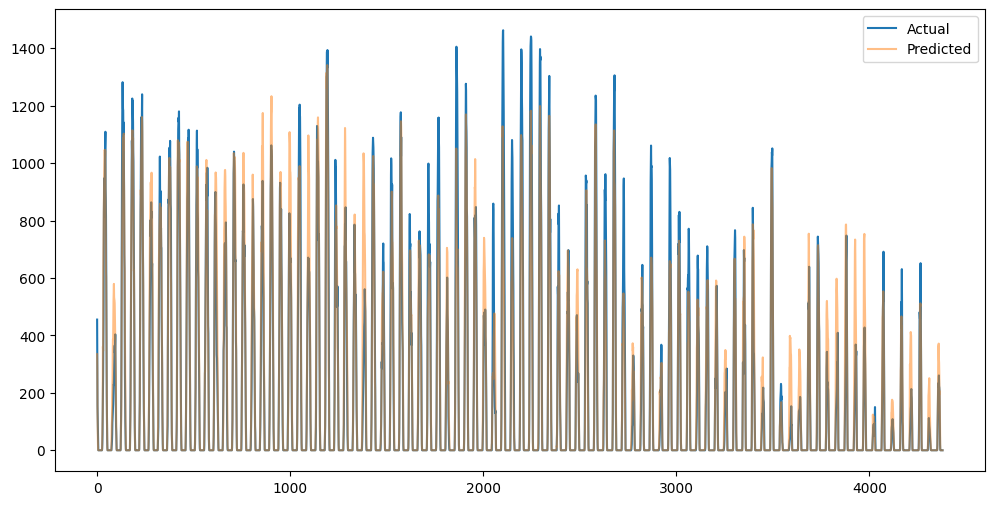

In [28]:
# Plot actual vs. predicted for the worst fold (Fold 3)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.5)
plt.legend()


--- Solar Ensemble ---
Model 0 - RMSE: 115.02, Weight: 0.0087
Model 1 - RMSE: 121.81, Weight: 0.0082
Model 2 - RMSE: 116.93, Weight: 0.0086
Model 3 - RMSE: 117.36, Weight: 0.0085
Model 4 - RMSE: 119.63, Weight: 0.0084
Model 5 - RMSE: 122.18, Weight: 0.0082
Model 6 - RMSE: 121.77, Weight: 0.0082
Model 7 - RMSE: 115.37, Weight: 0.0087
Model 8 - RMSE: 114.97, Weight: 0.0087
Model 9 - RMSE: 119.75, Weight: 0.0084
Model 10 - RMSE: 119.23, Weight: 0.0084
Model 11 - RMSE: 122.39, Weight: 0.0082
Model 12 - RMSE: 117.36, Weight: 0.0085
Model 13 - RMSE: 119.57, Weight: 0.0084
Model 14 - RMSE: 122.55, Weight: 0.0082
Model 15 - RMSE: 118.51, Weight: 0.0084
Model 16 - RMSE: 114.83, Weight: 0.0087
Model 17 - RMSE: 124.04, Weight: 0.0081
Model 18 - RMSE: 125.86, Weight: 0.0079
Model 19 - RMSE: 116.80, Weight: 0.0086
Model 20 - RMSE: 159.20, Weight: 0.0063
Model 21 - RMSE: 163.11, Weight: 0.0061
Model 22 - RMSE: 155.36, Weight: 0.0064
Model 23 - RMSE: 157.75, Weight: 0.0063
Model 24 - RMSE: 159.65, Weight: 0.0063
Model 25 - RMSE: 165.96, Weight: 0.0060
Model 26 - RMSE: 166.19, Weight: 0.0060
Model 27 - RMSE: 160.70, Weight: 0.0062
Model 28 - RMSE: 155.19, Weight: 0.0064
Model 29 - RMSE: 164.11, Weight: 0.0061
Model 30 - RMSE: 164.57, Weight: 0.0061
Model 31 - RMSE: 163.01, Weight: 0.0061
Model 32 - RMSE: 157.06, Weight: 0.0064
Model 33 - RMSE: 159.15, Weight: 0.0063
Model 34 - RMSE: 161.69, Weight: 0.0062
Model 35 - RMSE: 163.70, Weight: 0.0061
Model 36 - RMSE: 156.93, Weight: 0.0064
Model 37 - RMSE: 165.60, Weight: 0.0060
Model 38 - RMSE: 164.98, Weight: 0.0061
Model 39 - RMSE: 154.57, Weight: 0.0065

 Ensemble Metrics:
RMSE: 121.45
MAE: 61.30
R²: 0.9133

In [30]:
# do model
print("\n--- Solar Ensemble ---")
solar_preds = weighted_ensemble_prediction(X_train_solar_points, y_train_solar, X_test_solar_points, y_test_solar, n_estimators=500)

# one model takes about 60:120 seconds to run
# we got 40 or 44 can remember, so should be about an 80 min run time :(


--- Solar Ensemble ---
Model 0 - RMSE: 115.02, Weight: 0.0087
Model 1 - RMSE: 121.81, Weight: 0.0082
Model 2 - RMSE: 116.93, Weight: 0.0086
Model 3 - RMSE: 117.36, Weight: 0.0085
Model 4 - RMSE: 119.63, Weight: 0.0084
Model 5 - RMSE: 122.18, Weight: 0.0082
Model 6 - RMSE: 121.77, Weight: 0.0082
Model 7 - RMSE: 115.37, Weight: 0.0087
Model 8 - RMSE: 114.97, Weight: 0.0087
Model 9 - RMSE: 119.75, Weight: 0.0084
Model 10 - RMSE: 119.23, Weight: 0.0084
Model 11 - RMSE: 122.39, Weight: 0.0082
Model 12 - RMSE: 117.36, Weight: 0.0085
Model 13 - RMSE: 119.57, Weight: 0.0084
Model 14 - RMSE: 122.55, Weight: 0.0082
Model 15 - RMSE: 118.51, Weight: 0.0084
Model 16 - RMSE: 114.83, Weight: 0.0087
Model 17 - RMSE: 124.04, Weight: 0.0081
Model 18 - RMSE: 125.86, Weight: 0.0079
Model 19 - RMSE: 116.80, Weight: 0.0086
Model 20 - RMSE: 159.20, Weight: 0.0063
Model 21 - RMSE: 163.11, Weight: 0.0061
Model 22 - RMSE: 155.36, Weight: 0.0064
Model 23 - RMSE: 157.75, Weight: 0.0063
Model 24 - RMSE: 159.65, W



--- Wind Ensemble ---
Model 0 - RMSE: 254.71, Weight: 0.0039
Model 1 - RMSE: 254.78, Weight: 0.0039
Model 2 - RMSE: 255.59, Weight: 0.0039
Model 3 - RMSE: 256.62, Weight: 0.0039
Model 4 - RMSE: 257.64, Weight: 0.0039
Model 5 - RMSE: 259.11, Weight: 0.0039
Model 6 - RMSE: 253.80, Weight: 0.0039
Model 7 - RMSE: 250.91, Weight: 0.0040
Model 8 - RMSE: 251.59, Weight: 0.0040
Model 9 - RMSE: 252.59, Weight: 0.0040
Model 10 - RMSE: 253.54, Weight: 0.0039
Model 11 - RMSE: 255.84, Weight: 0.0039
Model 12 - RMSE: 252.88, Weight: 0.0040
Model 13 - RMSE: 253.64, Weight: 0.0039
Model 14 - RMSE: 250.16, Weight: 0.0040
Model 15 - RMSE: 249.92, Weight: 0.0040
Model 16 - RMSE: 249.82, Weight: 0.0040
Model 17 - RMSE: 251.88, Weight: 0.0040
Model 18 - RMSE: 251.48, Weight: 0.0040
Model 19 - RMSE: 252.91, Weight: 0.0040
Model 20 - RMSE: 249.25, Weight: 0.0040
Model 21 - RMSE: 245.51, Weight: 0.0041
Model 22 - RMSE: 242.17, Weight: 0.0041
Model 23 - RMSE: 242.77, Weight: 0.0041
Model 24 - RMSE: 251.48, Weight: 0.0040
Model 25 - RMSE: 252.91, Weight: 0.0040
Model 26 - RMSE: 249.25, Weight: 0.0040
Model 27 - RMSE: 245.51, Weight: 0.0041
Model 28 - RMSE: 242.17, Weight: 0.0041
Model 29 - RMSE: 242.77, Weight: 0.0041
Model 30 - RMSE: 254.08, Weight: 0.0039
Model 31 - RMSE: 251.39, Weight: 0.0040
Model 32 - RMSE: 248.75, Weight: 0.0040
Model 33 - RMSE: 244.13, Weight: 0.0041
Model 34 - RMSE: 242.29, Weight: 0.0041
Model 35 - RMSE: 240.47, Weight: 0.0042
Model 36 - RMSE: 374.32, Weight: 0.0027
Model 37 - RMSE: 380.82, Weight: 0.0026
Model 38 - RMSE: 385.19, Weight: 0.0026
Model 39 - RMSE: 360.26, Weight: 0.0028
Model 40 - RMSE: 357.18, Weight: 0.0028
Model 41 - RMSE: 373.20, Weight: 0.0027
Model 42 - RMSE: 352.77, Weight: 0.0028
Model 43 - RMSE: 345.28, Weight: 0.0029
Model 44 - RMSE: 358.03, Weight: 0.0028

 Ensemble Metrics:
RMSE: 252.38
MAE: 187.15
R²: 0.6678

In [3]:
# do model again but wind
print("\n--- Wind Ensemble ---")
wind_preds = weighted_ensemble_prediction(X_train_wind_points, y_train_wind, X_test_wind_points, y_test_wind, n_estimators=500)


--- Wind Ensemble ---
Model 0 - RMSE: 254.71, Weight: 0.0039
Model 1 - RMSE: 254.78, Weight: 0.0039
Model 2 - RMSE: 255.59, Weight: 0.0039
Model 3 - RMSE: 256.62, Weight: 0.0039
Model 4 - RMSE: 257.64, Weight: 0.0039
Model 5 - RMSE: 259.11, Weight: 0.0039
Model 6 - RMSE: 253.80, Weight: 0.0039
Model 7 - RMSE: 250.91, Weight: 0.0040
Model 8 - RMSE: 251.59, Weight: 0.0040
Model 9 - RMSE: 252.59, Weight: 0.0040
Model 10 - RMSE: 253.54, Weight: 0.0039
Model 11 - RMSE: 255.84, Weight: 0.0039
Model 12 - RMSE: 252.88, Weight: 0.0040
Model 13 - RMSE: 253.64, Weight: 0.0039
Model 14 - RMSE: 250.16, Weight: 0.0040
Model 15 - RMSE: 249.92, Weight: 0.0040
Model 16 - RMSE: 249.82, Weight: 0.0040
Model 17 - RMSE: 251.88, Weight: 0.0040
Model 18 - RMSE: 251.48, Weight: 0.0040
Model 19 - RMSE: 252.91, Weight: 0.0040
Model 20 - RMSE: 249.25, Weight: 0.0040
Model 21 - RMSE: 245.51, Weight: 0.0041
Model 22 - RMSE: 242.17, Weight: 0.0041
Model 23 - RMSE: 242.77, Weight: 0.0041
Model 24 - RMSE: 251.48, We


--- Wind Ensemble ---

[# DWD data normal single point]
 Individual Model Metrics:
Model 0 - RMSE: 254.71
Model 0 - MAE: 184.15
Model 0 - R²: 0.6617

[# NCEP data normal single point]
 Individual Model Metrics:
Model 1 - RMSE: 374.32
Model 1 - MAE: 289.77
Model 1 - R²: 0.2693

[# NCEP data normal + DWD data normal single points]
 Individual Model Metrics:
Model 2 - RMSE: 260.28
Model 2 - MAE: 193.61
Model 2 - R²: 0.6467

[# DWD data 2 points normal]
 Individual Model Metrics:
Model 3 - RMSE: 254.16
Model 3 - MAE: 183.57
Model 3 - R²: 0.6632

[# NCEP data 2 points normal]
 Individual Model Metrics:
Model 4 - RMSE: 376.37
Model 4 - MAE: 292.13
Model 4 - R²: 0.2613

 Ensemble Metrics:
RMSE: 277.07
MAE: 211.91
R²: 0.5997

In [28]:
# Testing different cobinations of data

X_train_wind_points_test = {}
X_scalars_wind_points_test = {}
X_test_wind_points_test = {}

# DWD data normal all points
X_train_wind_points_test[0] = pd.concat([X_train_wind_points[i] for i in range(36)], axis=1)
X_train_wind_points_test[0] = X_train_wind_points_test[0].loc[:, ~X_train_wind_points_test[0].columns.duplicated()]
X_test_wind_points_test[0] = pd.concat([X_test_wind_points[i] for i in range(36)], axis=1)
X_test_wind_points_test[0] = X_test_wind_points_test[0].loc[:, ~X_test_wind_points_test[0].columns.duplicated()]

# NCEP data normal all points
X_train_wind_points_test[1] = pd.concat([X_train_wind_points[i] for i in range(36,45)], axis=1)
X_train_wind_points_test[1] = X_train_wind_points_test[1].loc[:, ~X_train_wind_points_test[1].columns.duplicated()]
X_test_wind_points_test[1] = pd.concat([X_test_wind_points[i] for i in range(36,45)], axis=1)
X_test_wind_points_test[1] = X_test_wind_points_test[1].loc[:, ~X_test_wind_points_test[1].columns.duplicated()]

# DWD and NCEP data normal all points
X_train_wind_points_test[2] = pd.concat([X_train_wind_points[i] for i in range(45)], axis=1)
X_train_wind_points_test[2] = X_train_wind_points_test[2].loc[:, ~X_train_wind_points_test[2].columns.duplicated()]
X_test_wind_points_test[2] = pd.concat([X_test_wind_points[i] for i in range(45)], axis=1)
X_test_wind_points_test[2] = X_test_wind_points_test[2].loc[:, ~X_test_wind_points_test[2].columns.duplicated()]

# Check that is stored correctly
#print(X_train_wind_points_test[0].head(0))
#print(X_train_wind_points_test[1].head(0))
#print(X_train_wind_points_test[2].head(0))

# Call function to test
print("\n--- Wind Ensemble ---")
wind_preds_test = weighted_ensemble_prediction(X_train_wind_points_test, y_train_wind, X_test_wind_points_test, y_test_wind, n_estimators=500)


--- Wind Ensemble ---

 Individual Model Metrics:
Model 0 - RMSE: 247.43
Model 0 - MAE: 181.19
Model 0 - R²: 0.6807

 Individual Model Metrics:
Model 1 - RMSE: 343.58
Model 1 - MAE: 265.56
Model 1 - R²: 0.3844

 Individual Model Metrics:
Model 2 - RMSE: 259.44
Model 2 - MAE: 194.17
Model 2 - R²: 0.6490

 Ensemble Metrics:
RMSE: 264.35
MAE: 202.36
R²: 0.6356


562.2163837893498


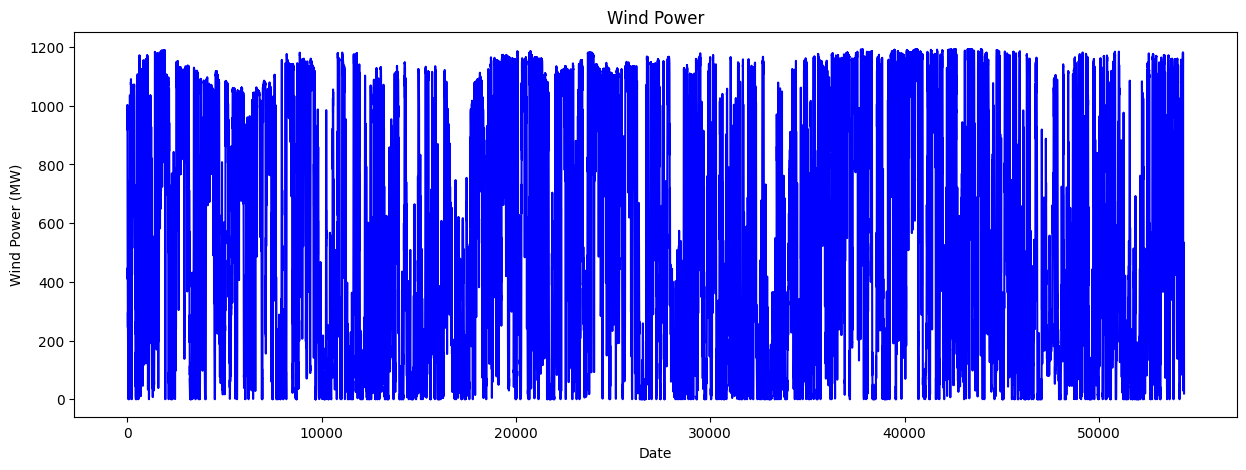

In [ ]:
# No outliers ...
#print(energy_data_Wind)
energy_data_Wind.plot(kind='line', title="Wind Power", figsize=(15, 5), color='blue')
plt.xlabel("Date")
plt.ylabel("Wind Power (MW)")
print(np.mean(energy_data_Wind)) #562.2163837893498

237.22469398547773


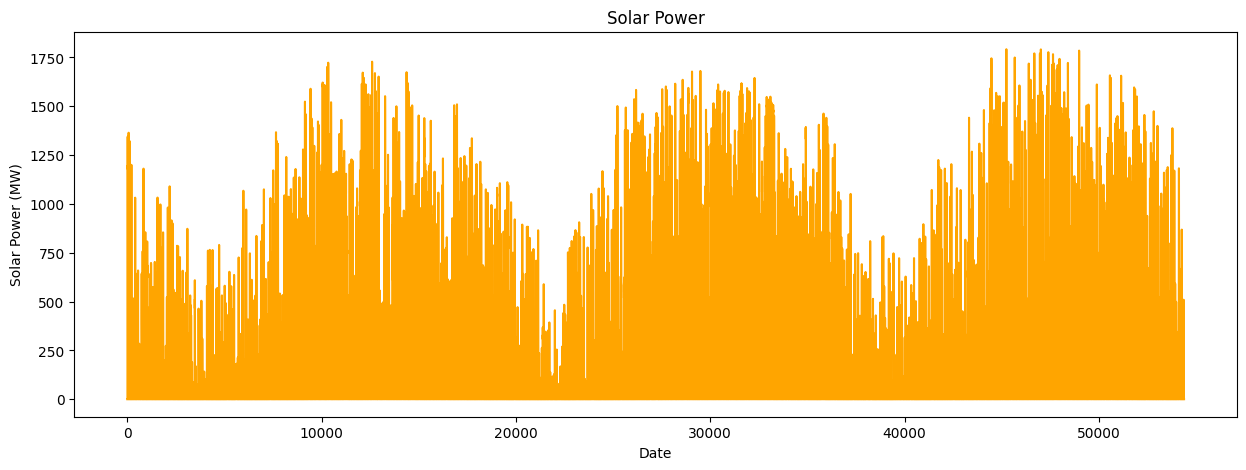

In [ ]:
energy_data_Solar.plot(kind='line', title="Solar Power", figsize=(15, 5), color='orange')
plt.xlabel("Date") 
plt.ylabel("Solar Power (MW)")
print(np.mean(energy_data_Solar)) # 237.22469398547773


In [11]:
# New forest tester
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

model_table = pd.read_csv("data/forecast_data_merged.csv")

In [2]:
print(model_table.head(0))
test = "valid_datetime"
#test = "ref_datetime"
vt = model_table[test]

# Convert "dtm" to datetime (ISO 8601, with UTC timezone)
model_table[test] = pd.to_datetime(model_table[test], utc=True)

# Sort just in case
model_table = model_table.sort_values(test)

# Calculate time deltas in hours
time_diffs = model_table[test].diff().dropna().dt.total_seconds() / 3600

# Frequency summary
interval_counts = time_diffs.value_counts().sort_index()

# Display start and end times
start_time = model_table[test].iloc[0]
end_time = model_table[test].iloc[-1]

print(f"Start time: {start_time}")
print(f"End time:   {end_time}\n")

# Display time interval frequencies
for interval, count in interval_counts.items():
    print(f"{interval:.1f}: {int(count)} occurrences")

print(f"\nTotal measurements: {len(model_table)}")
print(f"Unique intervals: {interval_counts.count()}")

credits = model_table["total_generation_MWh"]

print(credits.isna().sum()) # 0 wtf 


Empty DataFrame
Columns: [ref_datetime, valid_datetime, dwd_RelativeHumidity, dwd_WindDirection_100, dwd_WindSpeed_100, dwd_CloudCover, dwd_SolarDownwardRadiation, dwd_Temperature, ncep_RelativeHumidity, ncep_WindDirection_100, ncep_WindSpeed_100, ncep_CloudCover, ncep_SolarDownwardRadiation, ncep_Temperature, dtm, Solar_MW, Wind_MW, wind_curtailment_MW, wind_potential_MW, Solar_MWh_credit, Wind_MWh_credit, total_generation_MWh]
Index: []

[0 rows x 22 columns]
Start time: 2020-09-20 00:00:00+00:00
End time:   2023-10-27 05:30:00+00:00

0.5: 54347 occurrences

Total measurements: 54348
Unique intervals: 1
0


In [12]:
# Split the data into training and testing sets for solar and wind 
# Time gap that we're going to ignore
# Before: 2022-11-23 00:00:00
# After:  2022-12-06 18:00:00 

before_time = pd.Timestamp("2022-11-23 00:00:00+00:00")
after_time  = pd.Timestamp("2022-12-06 18:00:00+00:00")
end_time = pd.Timestamp("2023-10-27 23:30:00+00:00")

model_table['valid_datetime'] = pd.to_datetime(model_table['valid_datetime'])
train_and_valid = model_table[model_table["valid_datetime"] < before_time].copy()
test = model_table[(model_table["valid_datetime"] > after_time) & (model_table["valid_datetime"] <= end_time)].copy()

# Check the split
#print("Model table shape:", model_table.shape)  # (54348, 22
#print("Train and valid shape:", train_and_valid.shape)  # (38112, 22)
#print("Test shape:", test.shape)    # (15575, 22)

# Split into solar and wind data
wind_columns = [
    "valid_datetime",
    "dwd_RelativeHumidity", "dwd_WindDirection_100", "dwd_WindSpeed_100",
    "ncep_RelativeHumidity", "ncep_WindDirection_100", "ncep_WindSpeed_100",
    "wind_curtailment_MW"
]

solar_columns = [
    "valid_datetime",
    "dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
    "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"
]

# Create the training and testing sets for solar and wind 
X_train_solar = train_and_valid[solar_columns].copy()
X_train_wind = train_and_valid[wind_columns].copy()

X_test_solar = test[solar_columns].copy()
X_test_wind = test[wind_columns].copy()

y_train_solar = train_and_valid["Solar_MWh_credit"].copy()
y_train_wind = train_and_valid["Wind_MWh_credit"].copy()

y_test_solar = test["Solar_MWh_credit"].copy()
y_test_wind = test["Wind_MWh_credit"].copy()

In [9]:
# Feature engineering functions
def add_cyclic_time_features(df, dt_col="valid_datetime"):
    df = df.copy()
    df[dt_col] = pd.to_datetime(df[dt_col])

    df["hour_sin"] = np.sin(2 * np.pi * df[dt_col].dt.hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df[dt_col].dt.hour / 24)
    df["weekday_sin"] = np.sin(2 * np.pi * df[dt_col].dt.weekday / 7)
    df["weekday_cos"] = np.cos(2 * np.pi * df[dt_col].dt.weekday / 7)
    df["month_sin"] = np.sin(2 * np.pi * df[dt_col].dt.month / 12)
    df["month_cos"] = np.cos(2 * np.pi * df[dt_col].dt.month / 12)

    return df

def add_wind_direction_cyclic(df, wind_dir_col="WindDirection"):
    df = df.copy()
    radians = np.deg2rad(df[wind_dir_col])
    df["WindDirection_sin"] = np.sin(radians)
    df["WindDirection_cos"] = np.cos(radians)
    return df

def add_lag_features(df, columns, lags=[1]):
    df = df.copy()
    for col in columns:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df

def scale_features(df, scaler=None):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if scaler is None:
        scaler = MinMaxScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        df[numeric_cols] = scaler.transform(df[numeric_cols])

    return df, scaler

In [16]:
# Sort, is completely unnecessary but just in case
X_train_solar = X_train_solar.sort_values("valid_datetime")
X_train_wind = X_train_wind.sort_values("valid_datetime")
X_test_solar = X_test_solar.sort_values("valid_datetime")
X_test_wind = X_test_wind.sort_values("valid_datetime")

# add cyclic time features
X_train_solar = add_cyclic_time_features(X_train_solar, dt_col="valid_datetime")
X_train_wind = add_cyclic_time_features(X_train_wind, dt_col="valid_datetime")
X_test_solar = add_cyclic_time_features(X_test_solar, dt_col="valid_datetime")
X_test_wind = add_cyclic_time_features(X_test_wind, dt_col="valid_datetime")

# add wind direction cyclic features
for wind_col in ["dwd_WindDirection_100", "ncep_WindDirection_100"]:
    X_train_wind = add_wind_direction_cyclic(X_train_wind, wind_col)
    X_test_wind = add_wind_direction_cyclic(X_test_wind, wind_col)

# add lag features
sun_lag_columns = ["dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature", 
                    "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]
wind_lag_columns = ["dwd_RelativeHumidity", "dwd_WindSpeed_100",
                     "ncep_RelativeHumidity","ncep_WindSpeed_100"]

X_train_solar = add_lag_features(X_train_solar, columns=sun_lag_columns, lags=[-2, -1, 0, 1, 2])
X_train_wind = add_lag_features(X_train_wind, columns=wind_lag_columns, lags=[-2, -1, 0, 1, 2])
X_test_solar = add_lag_features(X_test_solar, columns=sun_lag_columns, lags=[-2, -1, 0, 1, 2])
X_test_wind = add_lag_features(X_test_wind, columns=wind_lag_columns, lags=[-2, -1, 0, 1, 2])

# drop NaNs caused by lagging
X_train_solar = X_train_solar.dropna()
X_train_wind = X_train_wind.dropna()
X_test_solar = X_test_solar.dropna()
X_test_wind = X_test_wind.dropna()

# drop corresponding y rows to keep things aligned
y_train_solar = y_train_solar.loc[X_train_solar.index]
y_train_wind = y_train_wind.loc[X_train_wind.index]
y_test_solar = y_test_solar.loc[X_test_solar.index]
y_test_wind = y_test_wind.loc[X_test_wind.index]

# Remove the colums used for feautre engineering
X_train_solar = X_train_solar.drop(columns=["valid_datetime","dwd_CloudCover","dwd_SolarDownwardRadiation",
                                            "dwd_Temperature",
                                            "ncep_CloudCover",
                                            "ncep_SolarDownwardRadiation", "ncep_Temperature"])
X_train_wind = X_train_wind.drop(columns=["valid_datetime","dwd_RelativeHumidity","dwd_WindDirection_100",
                                            "dwd_WindSpeed_100","ncep_RelativeHumidity",
                                            "ncep_WindDirection_100","ncep_WindSpeed_100"])
X_test_solar = X_test_solar.drop(columns=["valid_datetime","dwd_CloudCover","dwd_SolarDownwardRadiation",
                                            "dwd_Temperature",
                                            "ncep_CloudCover",
                                            "ncep_SolarDownwardRadiation", "ncep_Temperature"])
X_test_wind = X_test_wind.drop(columns=["valid_datetime","dwd_RelativeHumidity","dwd_WindDirection_100",
                                            "dwd_WindSpeed_100","ncep_RelativeHumidity",
                                            "ncep_WindDirection_100","ncep_WindSpeed_100"])

# add scaleing BE CAREFUL NOT TO PURJULÖK 
#X_train_solar, _ = scale_features(X_train_solar)
#X_test_solar, _ = scale_features(X_test_solar)
#X_train_wind, _ = scale_features(X_train_wind)
#X_test_wind, _ = scale_features(X_test_wind)

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

tscv = TimeSeriesSplit(n_splits=5, gap=2)
fold = 0
scores_rmse = []
scores_mae = []

for train_index, test_index in tscv.split(X_train_solar):
    # Split data (without scaling yet)
    X_train_raw = X_train_solar.iloc[train_index]
    X_test_raw = X_train_solar.iloc[test_index]
    y_train = y_train_solar.iloc[train_index]  
    y_test = y_train_solar.iloc[test_index]  

    # Scale features per-fold (no leakage)
    X_train, scaler = scale_features(X_train_raw, scaler=None)  # Fit on train only
    X_test, _ = scale_features(X_test_raw, scaler=scaler)       # Use same scaler

    # Train model
    model = RandomForestRegressor(n_estimators=500,
                                    max_depth=14,
                                    min_samples_split=10,    
                                    random_state=34,
                                    criterion='squared_error',
                                    n_jobs=-1
                                    )   
    #model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    scores_rmse.append(rmse)
    scores_mae.append(mae)

    fold += 1
    print(f"Fold {fold} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    #print(f"X_train describe:\n", X_train_raw.describe())
    print("-" * 50)

# Final results
print(f"Avg RMSE: {np.mean(scores_rmse):.2f} ± {np.std(scores_rmse):.2f}")
print(f"Avg MAE: {np.mean(scores_mae):.2f} ± {np.std(scores_mae):.2f}")

Fold 1 - RMSE: 73.87, MAE: 38.69
Train size: 6351, Test size: 6351
--------------------------------------------------
Fold 2 - RMSE: 58.25, MAE: 29.65
Train size: 12702, Test size: 6351
--------------------------------------------------
Fold 3 - RMSE: 40.56, MAE: 15.71
Train size: 19053, Test size: 6351
--------------------------------------------------
Fold 4 - RMSE: 48.86, MAE: 25.84
Train size: 25404, Test size: 6351
--------------------------------------------------
Fold 5 - RMSE: 42.50, MAE: 20.97
Train size: 31755, Test size: 6351
--------------------------------------------------
Avg RMSE: 52.81 ± 12.21
Avg MAE: 26.17 ± 7.81


model = RandomForestRegressor(n_estimators=500,max_depth=14,min_samples_split=10,random_state=42,criterion='squared_error',n_jobs=-1)

Runtime 4m 12,8s 

Fold 1 - RMSE: 73.67, MAE: 38.61
Train size: 6351, Test size: 6351
Fold 2 - RMSE: 57.98, MAE: 29.53
Train size: 12702, Test size: 6351
Fold 3 - RMSE: 40.57, MAE: 15.70
Train size: 19053, Test size: 6351
Fold 4 - RMSE: 48.85, MAE: 25.82
Train size: 25404, Test size: 6351
Fold 5 - RMSE: 42.60, MAE: 21.00
Train size: 31755, Test size: 6351
Avg RMSE: 52.73 ± 12.10
Avg MAE: 26.13 ± 7.78

Increasing n-estimatiors to 1000 gives: Pretty much the same results. 

Runtime: 8m 56.9s

Avg RMSE: 52.77 ± 12.14
Avg MAE: 26.14 ± 7.79

Decreasing n-estimators back to 500 and chaning to MAE instead of MSE gives

Runtime:
model = RandomForestRegressor(n_estimators=500,max_depth=14,min_samples_split=10,random_state=42,criterion='squared_error',n_jobs=-1)

Runtime 4m 12,8s 

Fold 1 - RMSE: 73.67, MAE: 38.61
Train size: 6351, Test size: 6351
Fold 2 - RMSE: 57.98, MAE: 29.53
Train size: 12702, Test size: 6351
Fold 3 - RMSE: 40.57, MAE: 15.70
Train size: 19053, Test size: 6351
Fold 4 - RMSE: 48.85, MAE: 25.82
Train size: 25404, Test size: 6351
Fold 5 - RMSE: 42.60, MAE: 21.00
Train size: 31755, Test size: 6351
Avg RMSE: 52.73 ± 12.10
Avg MAE: 26.13 ± 7.78

Increasing n-estimatiors to 1000 gives: Pretty much the same results. 

Runtime: 8m 56.9s

Avg RMSE: 52.77 ± 12.14
Avg MAE: 26.14 ± 7.79

Decreasing n-estimators back to 500 and chaning to MAE instead of MSE gives

Runtime: 47m 5.2m

Fold 1 - RMSE: 73.34, MAE: 38.42
Train size: 6351, Test size: 6351

did not complete for fold too long of a runtime

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

tscv = TimeSeriesSplit(n_splits=5, gap=2)
fold = 0
scores_rmse = []
scores_mae = []

for train_index, test_index in tscv.split(X_train_wind):
    # Split data (without scaling yet)
    X_train_raw = X_train_wind.iloc[train_index]
    X_test_raw = X_train_wind.iloc[test_index]
    y_train = y_train_wind.iloc[train_index]  
    y_test = y_train_wind.iloc[test_index]  

    # Scale features per-fold (no leakage)
    X_train, scaler = scale_features(X_train_raw, scaler=None)  # Fit on train only
    X_test, _ = scale_features(X_test_raw, scaler=scaler)       # Use same scaler

    # Train model
    model = RandomForestRegressor(n_estimators=500,
                                    max_depth=14,
                                    min_samples_split=10,    
                                    random_state=42,
                                    criterion='squared_error',
                                    n_jobs=-1
                                    )   
    #model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    scores_rmse.append(rmse)
    scores_mae.append(mae)

    fold += 1
    print(f"Fold {fold} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    #print(f"X_train describe:\n", X_train_raw.describe())
    print("-" * 50)

# Final results
print(f"Avg RMSE: {np.mean(scores_rmse):.2f} ± {np.std(scores_rmse):.2f}")
print(f"Avg MAE: {np.mean(scores_mae):.2f} ± {np.std(scores_mae):.2f}")

Fold 1 - RMSE: 64.98, MAE: 43.03
Train size: 6351, Test size: 6351
--------------------------------------------------
Fold 2 - RMSE: 65.11, MAE: 44.61
Train size: 12702, Test size: 6351
--------------------------------------------------
Fold 3 - RMSE: 63.70, MAE: 46.29
Train size: 19053, Test size: 6351
--------------------------------------------------
Fold 4 - RMSE: 60.04, MAE: 39.94
Train size: 25404, Test size: 6351
--------------------------------------------------
Fold 5 - RMSE: 54.56, MAE: 37.98
Train size: 31755, Test size: 6351
--------------------------------------------------
Avg RMSE: 61.68 ± 4.00
Avg MAE: 42.37 ± 3.03


In [ ]:
# Use model and check results
rf = RandomForestRegressor(n_estimators=500,
                            max_depth=14,
                            min_samples_split=10,    
                            random_state=42,
                            criterion='squared_error',
                            n_jobs=-1
                            )  

# Scale the entire training set
X_train_solar, scaler = scale_features(X_train_solar, scaler=None)
X_test_solar, _ = scale_features(X_test_solar, scaler=scaler)  # Use same scaler

rf.fit(X_train_solar, y_train_solar)
y_pred_solar = rf.predict(X_test_solar)

print("Solar Model:")
print(f"MAPE: {mean_absolute_percentage_error(y_pred_solar,y_test_solar)*100:.2f}%")
print(f"MAE: {mean_absolute_error(y_test_solar, y_pred_solar):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_solar, y_pred_solar)):.2f}")
print(f"R²: {r2_score(y_test_solar, y_pred_solar):.2f}")

X_train_wind, scaler = scale_features(X_train_wind, scaler=None)
X_test_wind, _ = scale_features(X_test_wind, scaler=scaler)  # Use same scaler 

rf.fit(X_train_wind, y_train_wind)
y_pred_wind = rf.predict(X_test_wind)


print("\nWind Model:")

print(f"MAPE: {mean_absolute_percentage_error(y_pred_wind,y_test_wind)*100:.2f}%")
print(f"MAE: {mean_absolute_error(y_test_wind, y_pred_wind):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_wind, y_pred_wind)):.2f}")
print(f"R²: {r2_score(y_test_wind, y_pred_wind):.2f}")

pred_total_generation = y_pred_solar + y_pred_wind
sol = test["total_generation_MWh"][2:-2]

print("\nTotal Generation:")
print(f"MAPE: {mean_absolute_percentage_error(pred_total_generation, sol)*100:.2f}%")
print(f"MAE: {mean_absolute_error(sol, pred_total_generation):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(sol, pred_total_generation)):.2f}")
print(f"R²: {r2_score(sol, pred_total_generation):.2f}")

Solar Model:
MAPE: 13.14%
MAE: 23.44
RMSE: 47.73
R²: 0.95

Wind Model:
MAPE: 0.32%
MAE: 45.83
RMSE: 72.07
R²: 0.89

Total Generation:
MAPE: 0.24%
MAE: 57.52
RMSE: 85.39
R²: 0.91


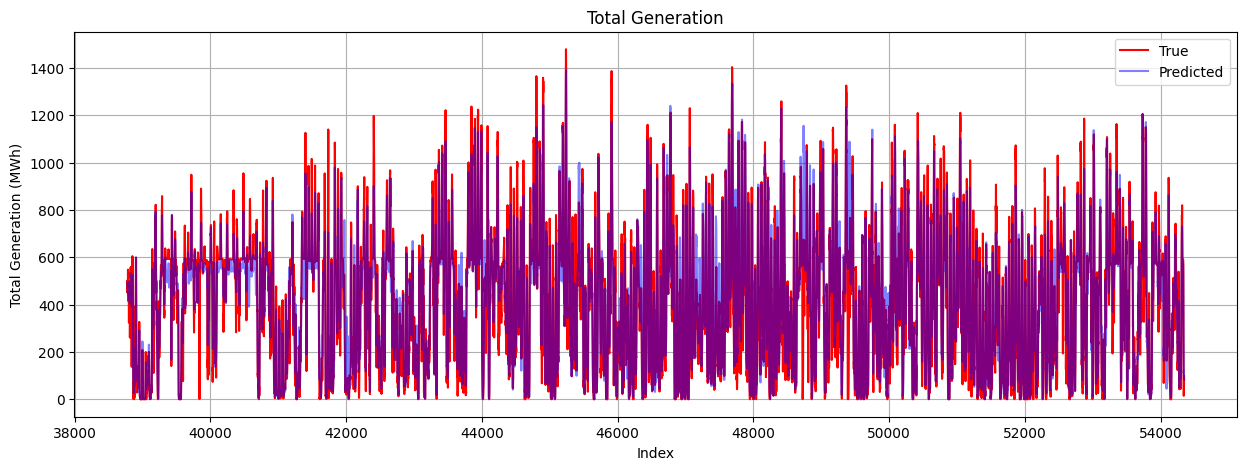

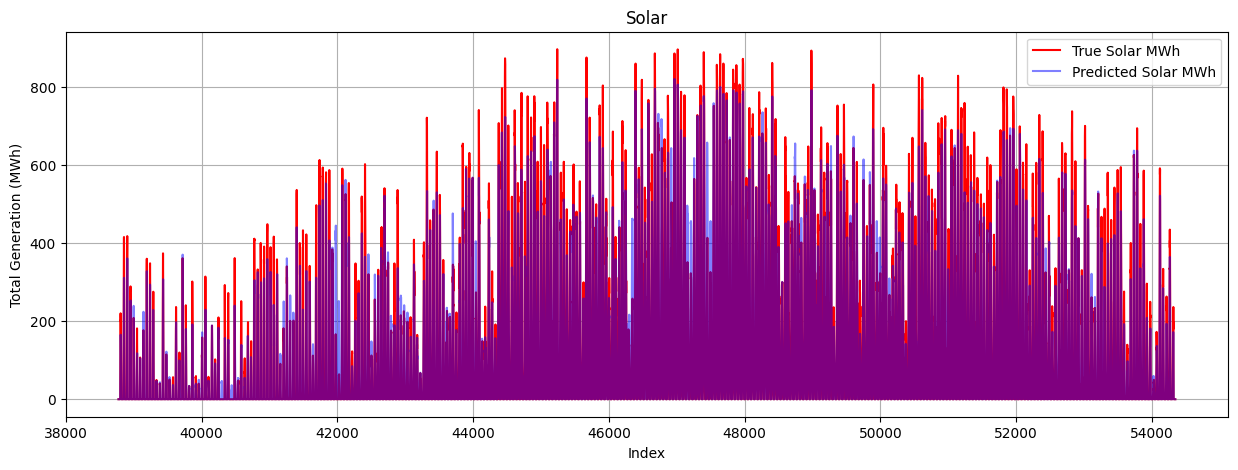

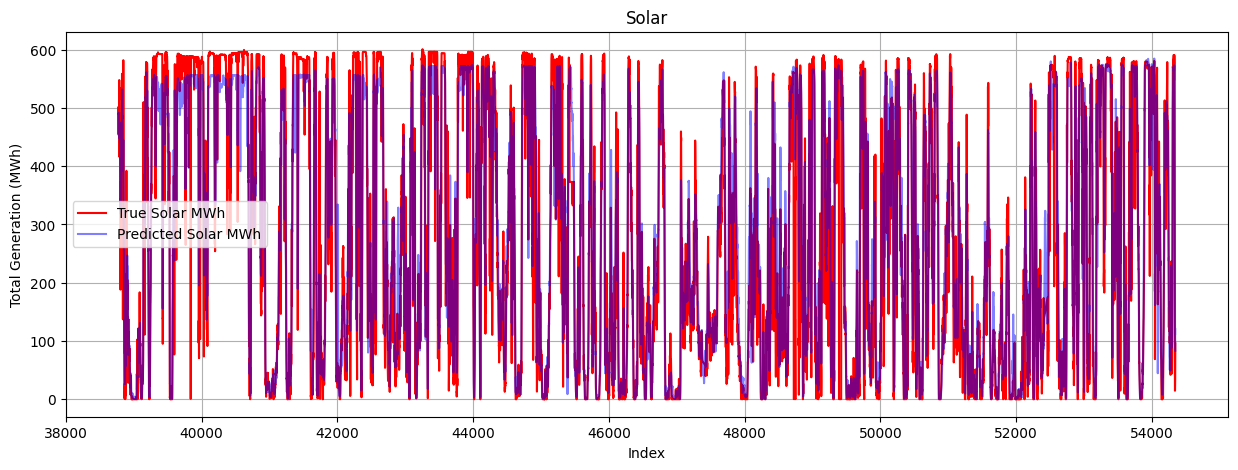

In [29]:
# Plotting the results
plt.figure(figsize=(15, 5))

plt.plot(sol.index, sol.values, label="True", color="red")
plt.plot(sol.index, pred_total_generation, label="Predicted", color="blue", alpha=0.5)

plt.title("Total Generation")
plt.xlabel("Index")
plt.ylabel("Total Generation (MWh)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 5))

plt.plot(y_test_solar.index, y_test_solar.values, label="True Solar MWh", color="red")
plt.plot(y_test_solar.index, y_pred_solar, label="Predicted Solar MWh", color="blue", alpha=0.5)

plt.title("Solar")
plt.xlabel("Index")
plt.ylabel("Total Generation (MWh)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 5))

plt.plot(y_test_wind.index, y_test_wind.values, label="True Solar MWh", color="red")
plt.plot(y_test_wind.index, y_pred_wind, label="Predicted Solar MWh", color="blue", alpha=0.5)

plt.title("Solar")
plt.xlabel("Index")
plt.ylabel("Total Generation (MWh)")
plt.legend()
plt.grid(True)
plt.show()


In [19]:

def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df):
    scores = [
        pinball(
            y=df["total_generation_MWh"],
            q=df[f"q{qu}"],
            alpha=qu/100
        ).mean()
        for qu in range(10, 100, 10)
    ]
    return np.mean(scores)

# For each quantile, predict it
def predict_quantiles(rf, X, quantiles=[0.1, 0.2, ..., 0.9]):
    all_tree_preds = np.stack([tree.predict(X) for tree in rf.estimators_], axis=1)
    preds = {}
    for q in quantiles:
        preds[f"q{int(q*100)}"] = np.percentile(all_tree_preds, q*100, axis=1)
    return preds


# Solar model
rf_solar = RandomForestRegressor(
    n_estimators=500,
    max_depth=14,
    min_samples_split=10,    
    random_state=42,
    criterion='squared_error',
    n_jobs=-1
)

rf_solar.fit(X_train_solar, y_train_solar)

# Wind model
rf_wind = RandomForestRegressor(
    n_estimators=500,
    max_depth=14,
    min_samples_split=10,    
    random_state=42,
    criterion='squared_error',
    n_jobs=-1
)

rf_wind.fit(X_train_wind, y_train_wind)

solar_tree_preds = np.stack([tree.predict(X_test_solar) for tree in rf_solar.estimators_], axis=1)
wind_tree_preds = np.stack([tree.predict(X_test_wind) for tree in rf_wind.estimators_], axis=1)

total_tree_preds = solar_tree_preds + wind_tree_preds

# Predict quantiles from total_tree_preds
quantile_preds = {}
for q in range(10, 100, 10):
    quantile_preds[f"q{q}"] = np.percentile(total_tree_preds, q, axis=1)

# Build evaluation DataFrame
eval_df = pd.DataFrame(quantile_preds)
eval_df["total_generation_MWh"] = sol.values  # careful about index alignment!

# Pinball Score
score = pinball_score(eval_df)

print(f"\nPinball score (mean over quantiles): {score:.4f}")


c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature


Pinball score (mean over quantiles): 23.1261


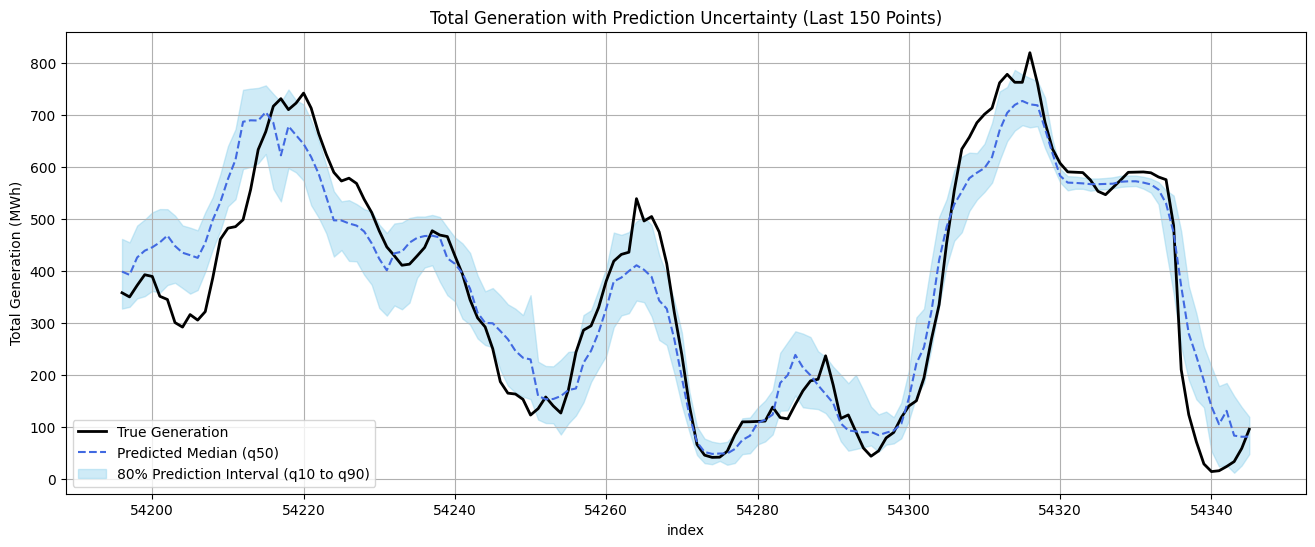

In [40]:
# enter number of points
N = 150
index_slice = sol.index[-N:]

true_values = sol.values[-N:]
median_pred = eval_df["q50"].values[-N:]
q10_pred = eval_df["q10"].values[-N:]
q90_pred = eval_df["q90"].values[-N:]

plt.figure(figsize=(16, 6))
plt.plot(index_slice, true_values, label="True Generation", color="black", linewidth=2)
plt.plot(index_slice, median_pred, label="Predicted Median (q50)", color="royalblue", linestyle="--")

plt.fill_between(
    index_slice,
    q10_pred,
    q90_pred,
    color="skyblue",
    alpha=0.4,
    label="80% Prediction Interval (q10 to q90)"
)

plt.title(f"Total Generation with Prediction Uncertainty (Last {N} Points)")
plt.xlabel("index")
plt.ylabel("Total Generation (MWh)")
plt.legend()
plt.grid(True)
plt.show()


In [1]:
# DO NOT FORGET TO UNCOMMENT WRITE TO FILE
# FILE STORED IN THE DATA FOLDER

# Preporssesing of data is done like in competition
# Most of the code is copued from the competition notebook ("Getting Started.ipynb")
# and modified to fit the needs of this project

# Reqeuired Libraries
import pandas as pd
import xarray as xr
import numpy as np
#import statsmodels.formula.api as smf
#from statsmodels.iolib.smpickle import load_pickle
#import comp_utils
#import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
#from matplotlib.ticker import MaxNLocator
#import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#import pickle as pkl


# load data and create a dataframe
# DWD data
dwd_Hornsea = xr.open_dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
subset = dwd_Hornsea[["RelativeHumidity", "WindDirection:100","WindSpeed:100"]]
avg_over_space = subset.mean(dim=["latitude","longitude"])
df_dwd_Hornsea = avg_over_space.to_dataframe().reset_index()
df_dwd_Hornsea["ref_datetime"] = df_dwd_Hornsea["ref_datetime"].dt.tz_localize("UTC")
df_dwd_Hornsea["valid_datetime"] = df_dwd_Hornsea["ref_datetime"] + pd.TimedeltaIndex(df_dwd_Hornsea["valid_datetime"],unit="hours")
df_dwd_Hornsea = df_dwd_Hornsea.rename(columns={
    "RelativeHumidity": "dwd_RelativeHumidity",
    "WindDirection:100": "dwd_WindDirection_100",
    "WindSpeed:100": "dwd_WindSpeed_100"
})

dwd_pes10 = xr.open_dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
subset = dwd_pes10[["CloudCover", "SolarDownwardRadiation","Temperature"]]
avg_over_space = subset.mean(dim=["point"])
df_dwd_pes10 = avg_over_space.to_dataframe().reset_index()
df_dwd_pes10["ref_datetime"] = df_dwd_pes10["ref_datetime"].dt.tz_localize("UTC")
df_dwd_pes10["valid_datetime"] = df_dwd_pes10["ref_datetime"] + pd.TimedeltaIndex(df_dwd_pes10["valid_datetime"],unit="hours")
df_dwd_pes10 = df_dwd_pes10.rename(columns={
    "CloudCover": "dwd_CloudCover",
    "SolarDownwardRadiation": "dwd_SolarDownwardRadiation",
    "Temperature": "dwd_Temperature"
})

# NCEP data
ncep_Hornsea = xr.open_dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
subset = ncep_Hornsea[["RelativeHumidity", "WindDirection:100","WindSpeed:100"]]
avg_over_space = subset.mean(dim=["latitude","longitude"])
df_ncep_Hornsea = avg_over_space.to_dataframe().reset_index()
df_ncep_Hornsea["ref_datetime"] = df_ncep_Hornsea["ref_datetime"].dt.tz_localize("UTC")
df_ncep_Hornsea["valid_datetime"] = df_ncep_Hornsea["ref_datetime"] + pd.TimedeltaIndex(df_ncep_Hornsea["valid_datetime"],unit="hours")
df_ncep_Hornsea = df_ncep_Hornsea.rename(columns={
    "RelativeHumidity": "ncep_RelativeHumidity",
    "WindDirection:100": "ncep_WindDirection_100",
    "WindSpeed:100": "ncep_WindSpeed_100"
})

ncep_pes10 = xr.open_dataset("data/ncep_gfs_pes10_20200920_20231027.nc")
subset = ncep_pes10[["CloudCover", "SolarDownwardRadiation","Temperature"]]
avg_over_space = subset.mean(dim=["point"])
df_ncep_pes10 = avg_over_space.to_dataframe().reset_index()
df_ncep_pes10["ref_datetime"] = df_ncep_pes10["ref_datetime"].dt.tz_localize("UTC")
df_ncep_pes10["valid_datetime"] = df_ncep_pes10["ref_datetime"] + pd.TimedeltaIndex(df_ncep_pes10["valid_datetime"],unit="hours")
df_ncep_pes10 = df_ncep_pes10.rename(columns={
    "CloudCover": "ncep_CloudCover",
    "SolarDownwardRadiation": "ncep_SolarDownwardRadiation",
    "Temperature": "ncep_Temperature"
})

# Merge dataframes
df_merged = df_dwd_Hornsea \
    .merge(df_dwd_pes10, how="outer",on=["ref_datetime","valid_datetime"]) \
    .merge(df_ncep_Hornsea, how="outer",on=["ref_datetime","valid_datetime"]) \
    .merge(df_ncep_pes10, how="outer",on=["ref_datetime","valid_datetime"])

df_merged = df_merged.set_index("valid_datetime").groupby("ref_datetime").resample("30T").interpolate("linear")
df_merged = df_merged.drop(columns="ref_datetime",axis=1).reset_index()

# print("number of nans in the data:")
# print(df_merged.isna().sum().sum())
# No NaNs in the data great move on to energy data

# Load energy data
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv") 

energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]
energy_data_wind_curtailment = energy_data["boa_MWh"]

# Repair energy data, there are no time gaps but some NaNs, use linear interpolation
energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)
energy_data["Solar_MW"] = energy_data_Solar

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)
energy_data["Wind_MW"] = energy_data_Wind

energy_data_wind_curtailment = energy_data_wind_curtailment.sort_index()
energy_data_wind_curtailment.interpolate(method='linear', inplace=True)
energy_data["boa_MWh"] = energy_data_wind_curtailment

# Calculate cutailment
energy_data['wind_curtailment_MW'] = -energy_data['boa_MWh'] / 0.5
energy_data['wind_potential_MW'] = energy_data['Wind_MW'] + energy_data['wind_curtailment_MW']

# TARGET MWh!!! 
energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]
energy_data["total_generation_MWh"] = energy_data["Wind_MWh_credit"] + energy_data["Solar_MWh_credit"]

energy_export = energy_data[[
    'dtm',
    'Solar_MW',
    'Wind_MW',
    'wind_curtailment_MW',
    'wind_potential_MW',
    'Solar_MWh_credit',
    'Wind_MWh_credit',
    'total_generation_MWh',
]]

# Convert dtm to datetime
energy_export = energy_export.copy()
energy_export['dtm'] = pd.to_datetime(energy_export['dtm'], utc=True)

df_merged = df_merged.merge(energy_export, how="inner", left_on="valid_datetime", right_on="dtm")
df_merged = df_merged[df_merged["valid_datetime"] - df_merged["ref_datetime"] < np.timedelta64(50,"h")]

display(df_merged)
# Save to CSVs
#df_merged.to_csv("data/forecast_data_merged_2.csv", index=False)


#print(len(energy_data_Wind)) # 54384
#print(len(df_merged)) # 54348
# They don't line up unforunately
# why?
# gud vet

,ref_datetime,valid_datetime,dwd_RelativeHumidity,dwd_WindDirection_100,dwd_WindSpeed_100,dwd_CloudCover,dwd_SolarDownwardRadiation,dwd_Temperature,ncep_RelativeHumidity,ncep_WindDirection_100,...,ncep_SolarDownwardRadiation,ncep_Temperature,dtm,Solar_MW,Wind_MW,wind_curtailment_MW,wind_potential_MW,Solar_MWh_credit,Wind_MWh_credit,total_generation_MWh
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,85.213753,62.085171,11.802604,0.450405,0.000000,13.646173,84.066666,58.721077,...,0.0,13.940016,2020-09-20 00:00:00+00:00,0.0,996.284,-0.0,996.284,0.0,498.142,498.142
1,2020-09-20 00:00:00+00:00,2020-09-20 00:30:00+00:00,85.012268,61.726974,11.648818,0.472211,0.000000,13.658508,84.433334,58.494644,...,0.0,13.896579,2020-09-20 00:30:00+00:00,0.0,957.576,-0.0,957.576,0.0,478.788,478.788
2,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,84.810783,61.368782,11.495032,0.494018,0.000000,13.670843,84.800003,58.268215,...,0.0,13.853142,2020-09-20 01:00:00+00:00,0.0,941.044,-0.0,941.044,0.0,470.522,470.522
3,2020-09-20 00:00:00+00:00,2020-09-20 01:30:00+00:00,84.357895,61.111046,11.354128,0.520214,0.000000,13.732101,84.933334,59.550636,...,0.0,13.847113,2020-09-20 01:30:00+00:00,0.0,964.366,-0.0,964.366,0.0,482.183,482.183
4,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,83.904999,60.853313,11.213223,0.546410,0.000000,13.793360,85.066666,60.833061,...,0.0,13.841084,2020-09-20 02:00:00+00:00,0.0,918.432,-0.0,918.432,0.0,459.216,459.216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459719,2023-10-27 00:00:00+00:00,2023-10-27 21:30:00+00:00,80.259064,177.495087,2.620757,0.549926,-0.003020,8.741467,81.199997,203.196014,...,0.0,8.939342,2023-10-27 21:30:00+00:00,0.0,275.444,-0.0,275.444,0.0,137.722,137.722
3459720,2023-10-27 00:00:00+00:00,2023-10-27 22:00:00+00:00,79.186958,172.861191,2.756150,0.585028,-0.011098,8.610748,80.122223,209.989487,...,0.0,8.804339,2023-10-27 22:00:00+00:00,0.0,132.522,-0.0,132.522,0.0,66.261,66.261
3459721,2023-10-27 00:00:00+00:00,2023-10-27 22:30:00+00:00,79.410889,173.374680,3.079223,0.676564,-0.004312,8.533447,79.872223,208.122833,...,0.0,8.769360,2023-10-27 22:30:00+00:00,0.0,64.226,-0.0,64.226,0.0,32.113,32.113
3459722,2023-10-27 00:00:00+00:00,2023-10-27 23:00:00+00:00,79.634819,173.888168,3.402297,0.768100,0.002474,8.456146,79.622223,206.256165,...,0.0,8.734381,2023-10-27 23:00:00+00:00,0.0,28.662,-0.0,28.662,0.0,14.331,14.331


In [ ]:
#df_merged.to_csv("data/forecast_data_merged_2.csv", index=False)
print(df_merged[98:104])

                 ref_datetime            valid_datetime  dwd_RelativeHumidity  \
99  2020-09-20 00:00:00+00:00 2020-09-22 01:30:00+00:00             84.682938   
769 2020-09-20 06:00:00+00:00 2020-09-20 06:00:00+00:00             82.922577   
770 2020-09-20 06:00:00+00:00 2020-09-20 06:30:00+00:00             83.550873   
771 2020-09-20 06:00:00+00:00 2020-09-20 07:00:00+00:00             84.179176   
772 2020-09-20 06:00:00+00:00 2020-09-20 07:30:00+00:00             83.528473   

     dwd_WindDirection_100  dwd_WindSpeed_100  dwd_CloudCover  \
99              204.539368           5.025789        0.296518   
769              52.993855          10.945393        0.675504   
770              54.844742          10.757450        0.627284   
771              56.695625          10.569509        0.579063   
772              58.685055          10.230618        0.551064   

     dwd_SolarDownwardRadiation  dwd_Temperature  ncep_RelativeHumidity  \
99                    -0.003056        10.94794